# Time Series Forecasting of Stock Prices


### 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima # Optional: for automatic ARIMA order selection
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.model_selection import train_test_split # Alternative split method
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from datetime import timedelta
import warnings
from scipy.stats.mstats import winsorize
from pmdarima import auto_arima
import itertools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")

# Set default figure size
plt.rcParams['figure.figsize'] = (12, 6)

### 2. Configuration and Helper Functions

In [20]:
# --- Configuration ---
FILE_PATH = "C:/Users/Legion/OneDrive - Humber College/ML 2/Final project/Stock price V2/Stock_Data.xlsx"
TARGET_COLUMN = 'Adj Close'
DATE_COLUMN = 'Date'
TEST_SIZE = 0.2 # 20% for testing
FORECAST_HORIZON_EXTENDED = 90 # Days for long-term forecast beyond test set
FREQ = 'B' # Business day frequency

# Decomposition period (Adjust and justify based on data/domain knowledge)
# Common choices: 5 (weekly), 21/22 (monthly), 63 (quarterly), 252 (annual)
DECOMP_PERIOD = 30 # Example: Using 30 for potential monthly patterns

# Model Parameters (Explain choices - fixed here for demonstration)
ARIMA_ORDER = (5, 1, 1) # Example: (p,d,q) - Needs justification (ACF/PACF, auto_arima)
ETS_TREND = 'add'       # Example: 'add', 'mul', None
ETS_SEASONAL = None     # Example: 'add', 'mul', None (Stocks usually don't have strong ETS seasonality)
ETS_SEASONAL_PERIODS = None # Only if ETS_SEASONAL is not None

# LSTM Parameters
LSTM_LOOK_BACK = 60 # Number of previous time steps to use as input features
LSTM_EPOCHS = 50
LSTM_BATCH_SIZE = 32

# --- Helper Functions ---

def load_and_preprocess(file_path, sheet_name, date_col, value_col, freq='B'):
    """Loads data from an Excel sheet, preprocesses, and returns a time series."""
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        df.columns = df.columns.str.strip() # Clean column names

        if date_col not in df.columns or value_col not in df.columns:
            print(f"Warning: Required columns ('{date_col}', '{value_col}') not found in sheet '{sheet_name}'. Skipping.")
            return None

        df = df[[date_col, value_col]].copy()
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=[date_col, value_col])
        df = df.sort_values(by=date_col)
        df = df.set_index(date_col)

        # Ensure unique index and handle potential duplicates (e.g., take mean)
        df = df[~df.index.duplicated(keep='first')]

        # Resample to the desired frequency and forward fill missing values
        ts = df[value_col].asfreq(freq, method='ffill')
        print(f"Loaded sheet '{sheet_name}', {len(ts)} data points after resampling to '{freq}'.")
        return ts
    except Exception as e:
        print(f"Error loading sheet '{sheet_name}': {e}")
        return None

def perform_adf_test(series, series_name="Time Series"):
    """Performs and prints the Augmented Dickey-Fuller test results."""
    print(f"\n--- ADF Test for {series_name} ---")
    result = adfuller(series.dropna()) # Drop NAs before test
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print(f"Conclusion: p-value is less than 0.05. The {series_name} is likely stationary.")
    else:
        print(f"Conclusion: p-value is greater than 0.05. The {series_name} is likely non-stationary.")
    return result[1] # Return p-value

def plot_diagnostics(series, series_name="Time Series"):
    """Plots time series, histogram, and box plot."""
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # Time Series Plot
    series.plot(ax=axes[0], title=f'{series_name} - Time Series Plot')
    axes[0].set_ylabel('Value')
    axes[0].grid(True)

    # Histogram
    series.hist(ax=axes[1], bins=30)
    axes[1].set_title(f'{series_name} - Histogram')
    axes[1].set_ylabel('Frequency')

    # Box Plot
    sns.boxplot(x=series, ax=axes[2])
    axes[2].set_title(f'{series_name} - Box Plot (Outlier Check)')

    plt.tight_layout()
    plt.show()

def plot_decomposition(series, model_type='additive', period=30, series_name="Time Series"):
    """Performs and plots time series decomposition."""
    try:
        decomposition = seasonal_decompose(series.dropna(), model=model_type, period=period)
        print(f"\n--- {model_type.capitalize()} Decomposition for {series_name} (Period={period}) ---")

        fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
        decomposition.observed.plot(ax=axes[0], legend=False)
        axes[0].set_ylabel('Observed')
        axes[0].set_title(f'{series_name} - {model_type.capitalize()} Decomposition')
        decomposition.trend.plot(ax=axes[1], legend=False)
        axes[1].set_ylabel('Trend')
        decomposition.seasonal.plot(ax=axes[2], legend=False)
        axes[2].set_ylabel('Seasonal')
        decomposition.resid.plot(ax=axes[3], legend=False)
        axes[3].set_ylabel('Residual')
        axes[3].set_xlabel('Date')
        fig.tight_layout()
        plt.show()
    except ValueError as ve:
        print(f"Could not perform {model_type} decomposition for {series_name}: {ve}. Series might be too short for period {period}.")
    except Exception as e:
         print(f"An error occurred during {model_type} decomposition for {series_name}: {e}")


def evaluate_forecast(y_true, y_pred, model_name="Model"):
    """Calculates and returns common evaluation metrics."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mse = mean_squared_error(y_true, y_pred)
    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"MSE:  {mse:.4f}")
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'MSE': mse}

def plot_forecast(train, test, forecast, future_forecast_dates=None, future_forecast_values=None, model_name="Model", series_name="Time Series"):
    """Plots the training data, actual test data, and forecasted values."""
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Test Data', color='orange')
    plt.plot(test.index, forecast, label=f'{model_name} Forecast', color='green', linestyle='--')

    if future_forecast_dates is not None and future_forecast_values is not None:
         plt.plot(future_forecast_dates, future_forecast_values, label=f'{model_name} Future Forecast', color='red', linestyle=':')

    plt.title(f'{series_name} - {model_name} Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


### 3. Data Loading and Initial Exploration Loop

Found sheets: ['MARA', 'SOXL', 'TD_BANK', 'NVDA', 'MANULIFE']

===== Processing Sheet: MARA =====
Loaded sheet 'MARA', 536 data points after resampling to 'B'.


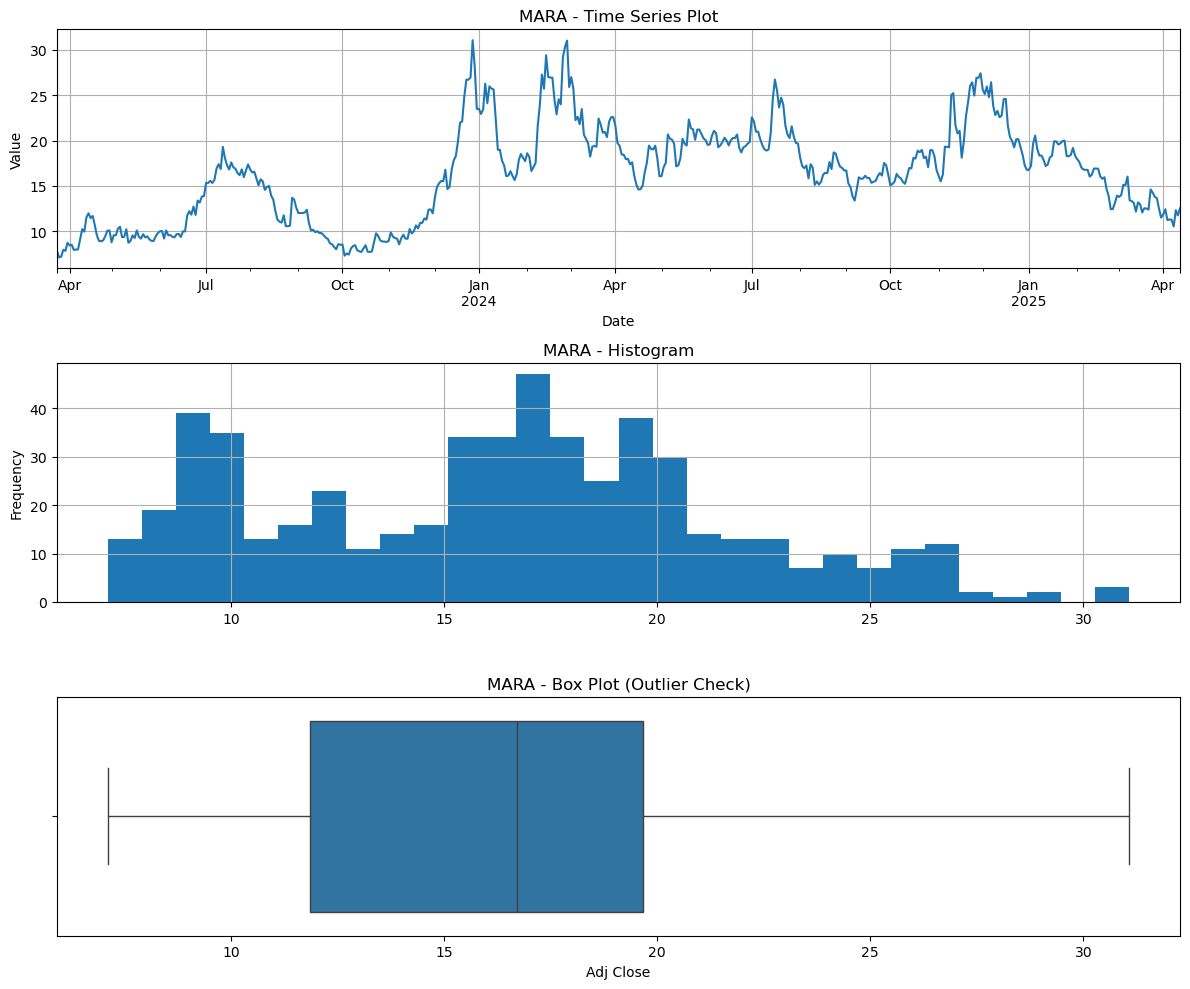


===== Processing Sheet: SOXL =====
Loaded sheet 'SOXL', 536 data points after resampling to 'B'.


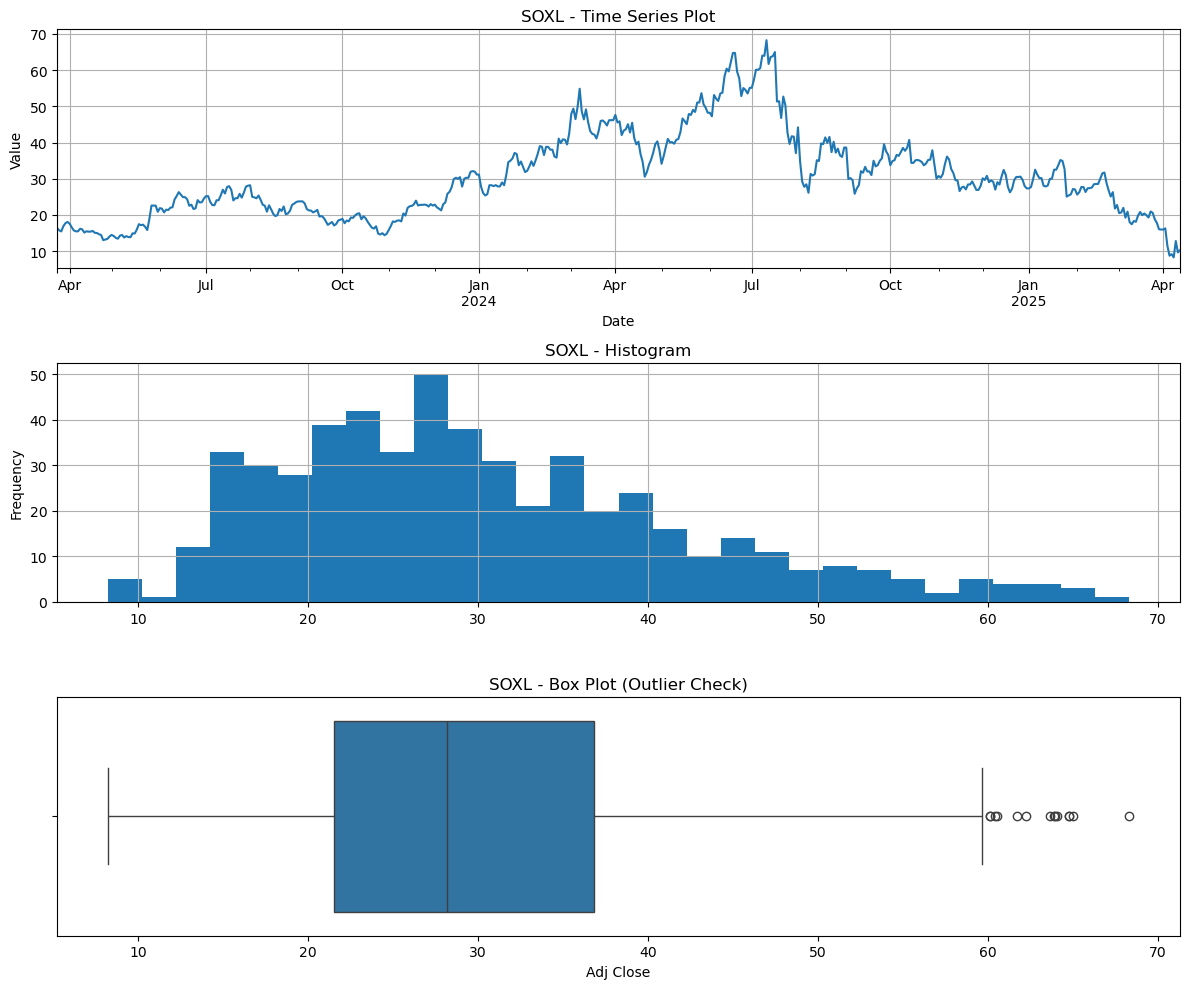


===== Processing Sheet: TD_BANK =====
Loaded sheet 'TD_BANK', 536 data points after resampling to 'B'.


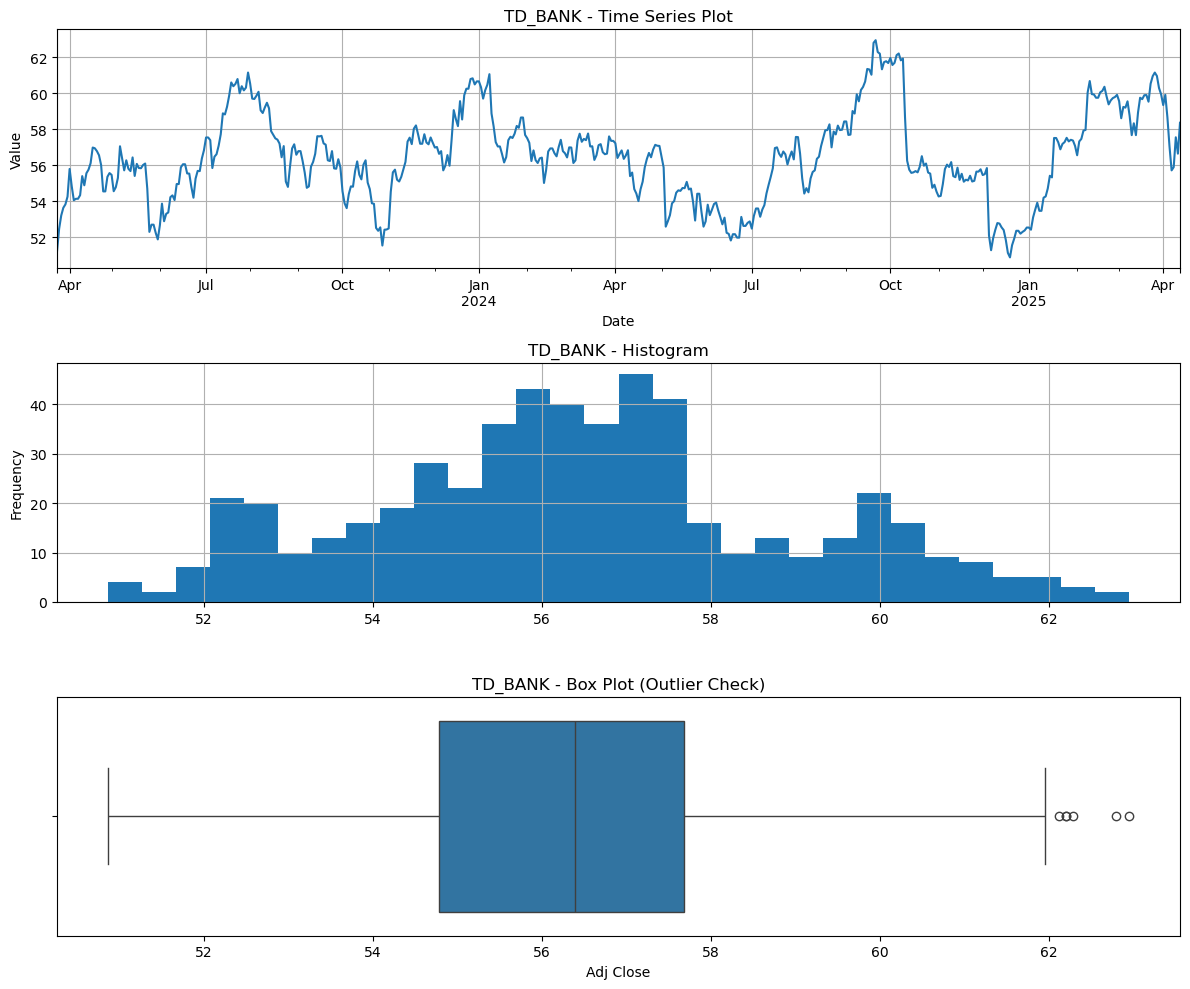


===== Processing Sheet: NVDA =====
Loaded sheet 'NVDA', 536 data points after resampling to 'B'.


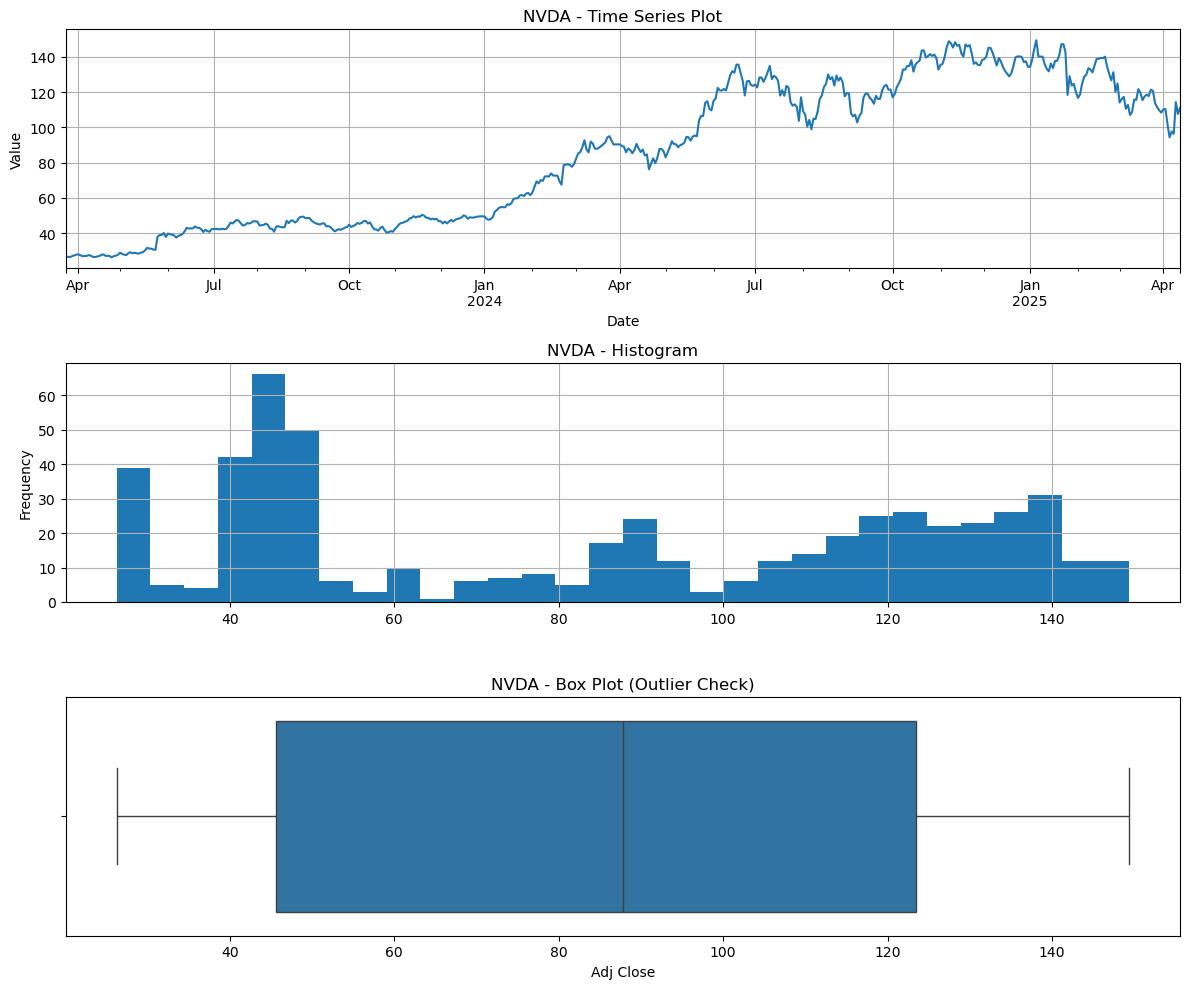


===== Processing Sheet: MANULIFE =====
Loaded sheet 'MANULIFE', 536 data points after resampling to 'B'.


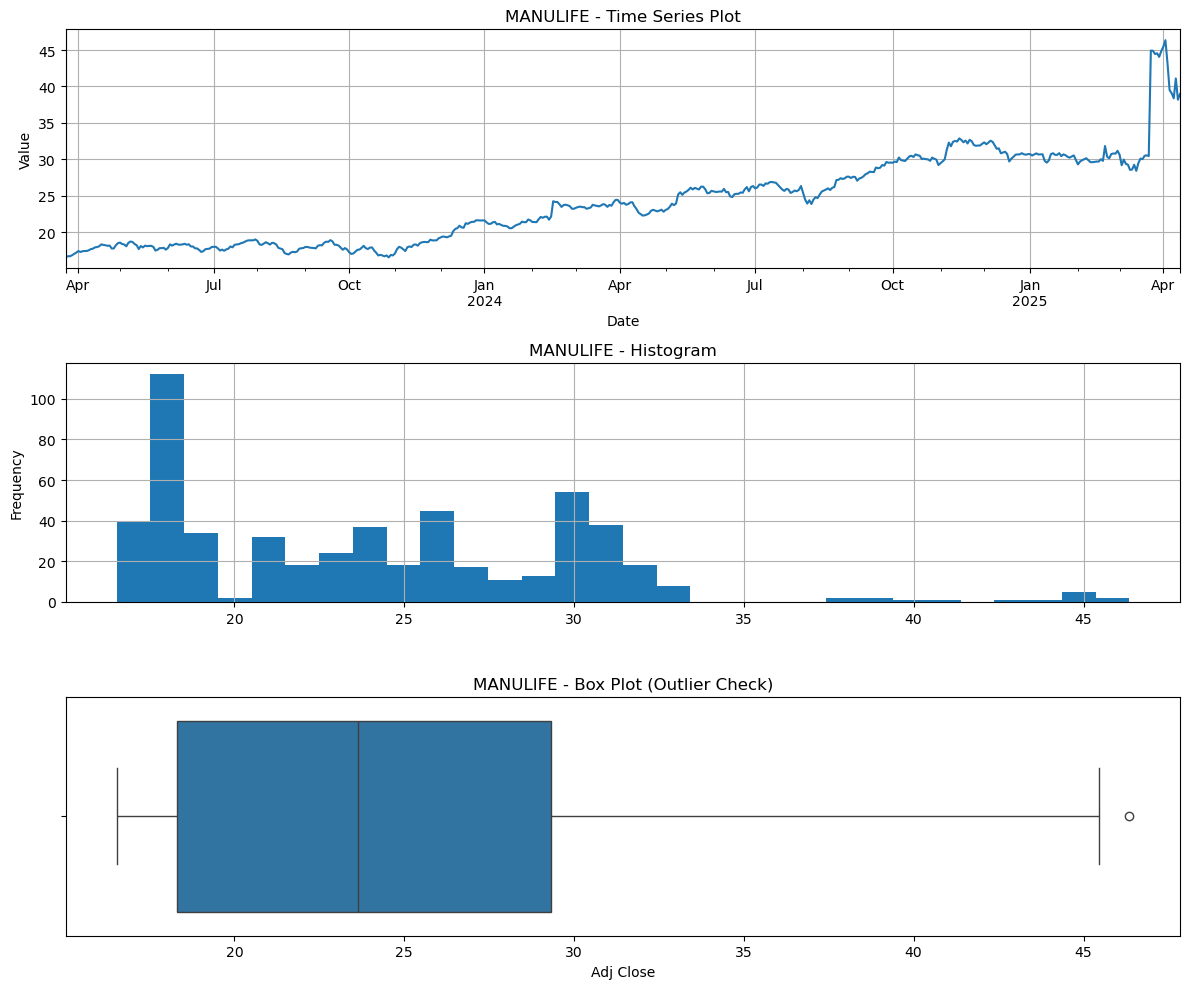

In [22]:
try:
    xlsx = pd.ExcelFile(FILE_PATH)
    sheet_names = xlsx.sheet_names
    print(f"Found sheets: {sheet_names}")
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}")
    sheet_names = [] # Stop execution if file not found

all_ts_data = {}
if sheet_names:
    for sheet in sheet_names:
        print(f"\n===== Processing Sheet: {sheet} =====")
        ts = load_and_preprocess(FILE_PATH, sheet, date_col=DATE_COLUMN, value_col=TARGET_COLUMN, freq=FREQ)
        if ts is not None and not ts.empty:
            all_ts_data[sheet] = ts
            plot_diagnostics(ts, series_name=sheet)
        else:
            print(f"Skipping sheet {sheet} due to loading/preprocessing errors or empty data.")
else:
     print("No sheets found or file could not be opened. Stopping.")

### 5. Stationarity Check and Decomposition Loop


===== Stationarity & Decomposition for: MARA =====

--- ADF Test for MARA (Original) ---
ADF Statistic: -2.8869
p-value: 0.0469
Critical Values:
	1%: -3.4429
	5%: -2.8671
	10%: -2.5697
Conclusion: p-value is less than 0.05. The MARA (Original) is likely stationary.

--- Additive Decomposition for MARA (Period=30) ---


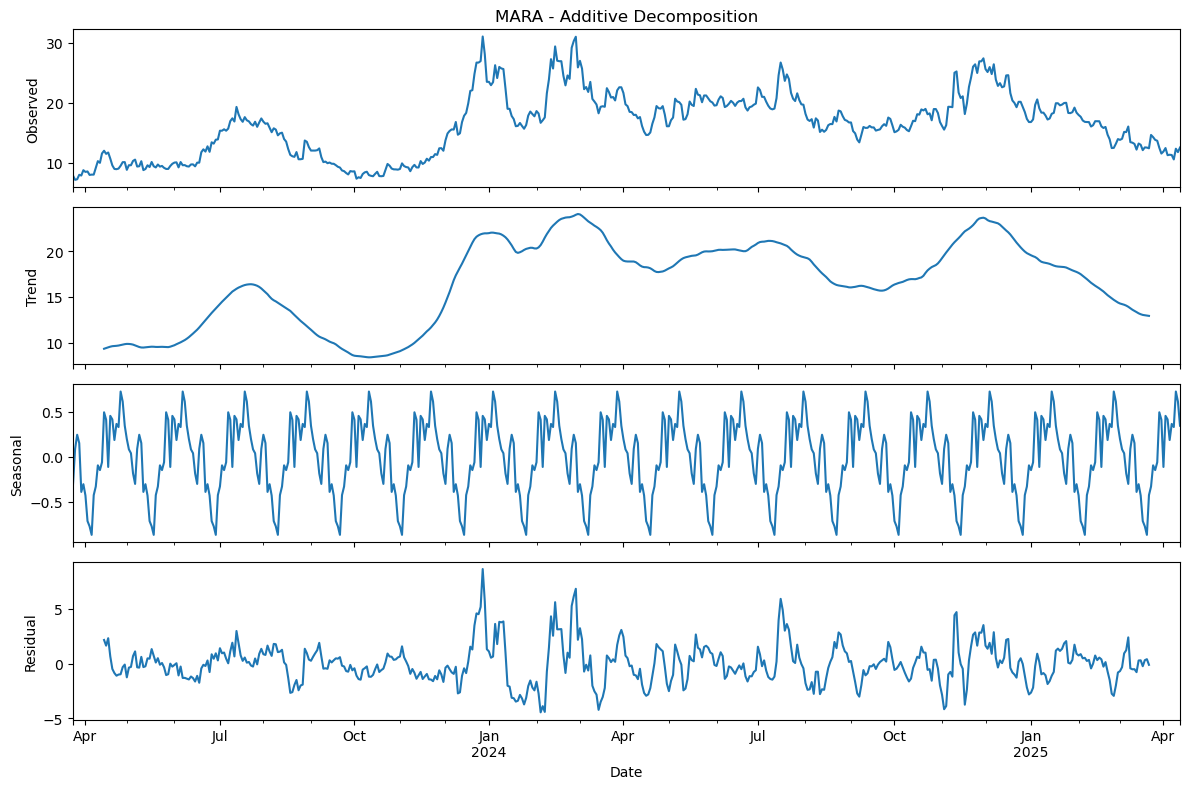


--- Multiplicative Decomposition for MARA (Period=30) ---


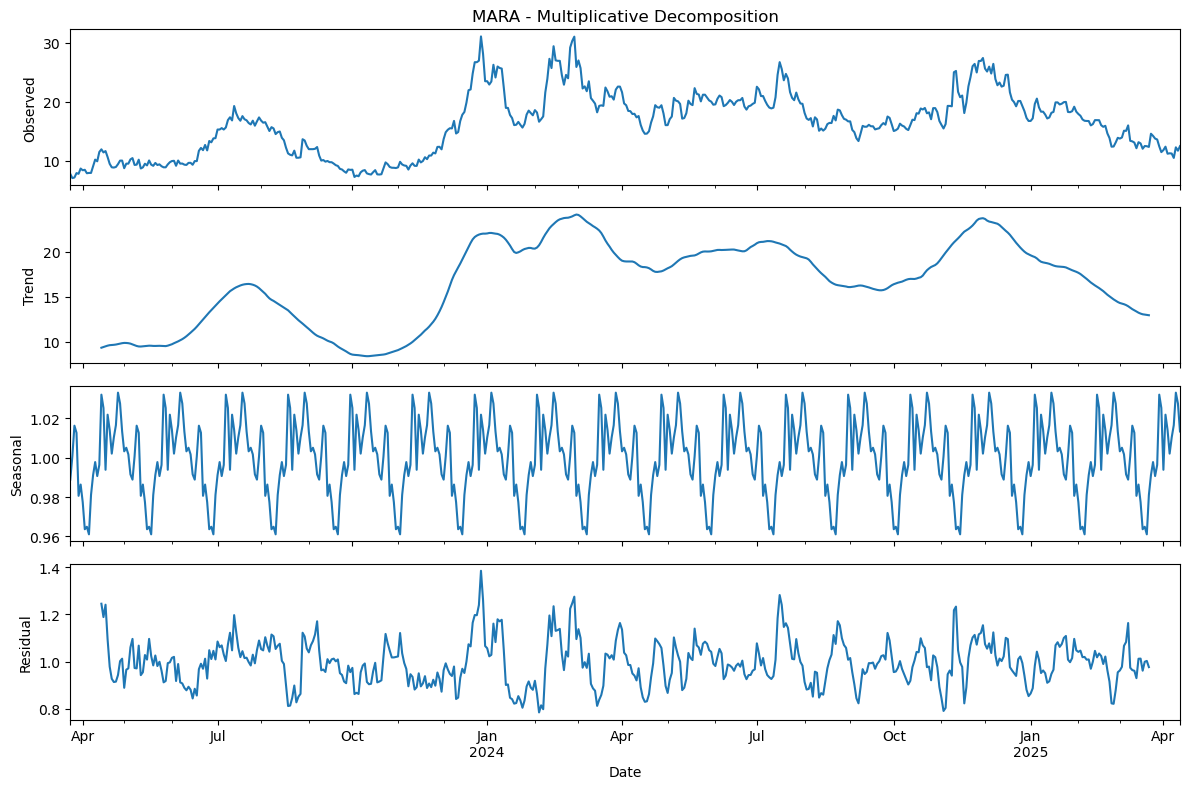


===== Stationarity & Decomposition for: SOXL =====

--- ADF Test for SOXL (Original) ---
ADF Statistic: -1.6519
p-value: 0.4560
Critical Values:
	1%: -3.4429
	5%: -2.8671
	10%: -2.5697
Conclusion: p-value is greater than 0.05. The SOXL (Original) is likely non-stationary.

--- ADF Test for SOXL (First Difference) ---
ADF Statistic: -6.8821
p-value: 0.0000
Critical Values:
	1%: -3.4429
	5%: -2.8671
	10%: -2.5697
Conclusion: p-value is less than 0.05. The SOXL (First Difference) is likely stationary.

--- Additive Decomposition for SOXL (Period=30) ---


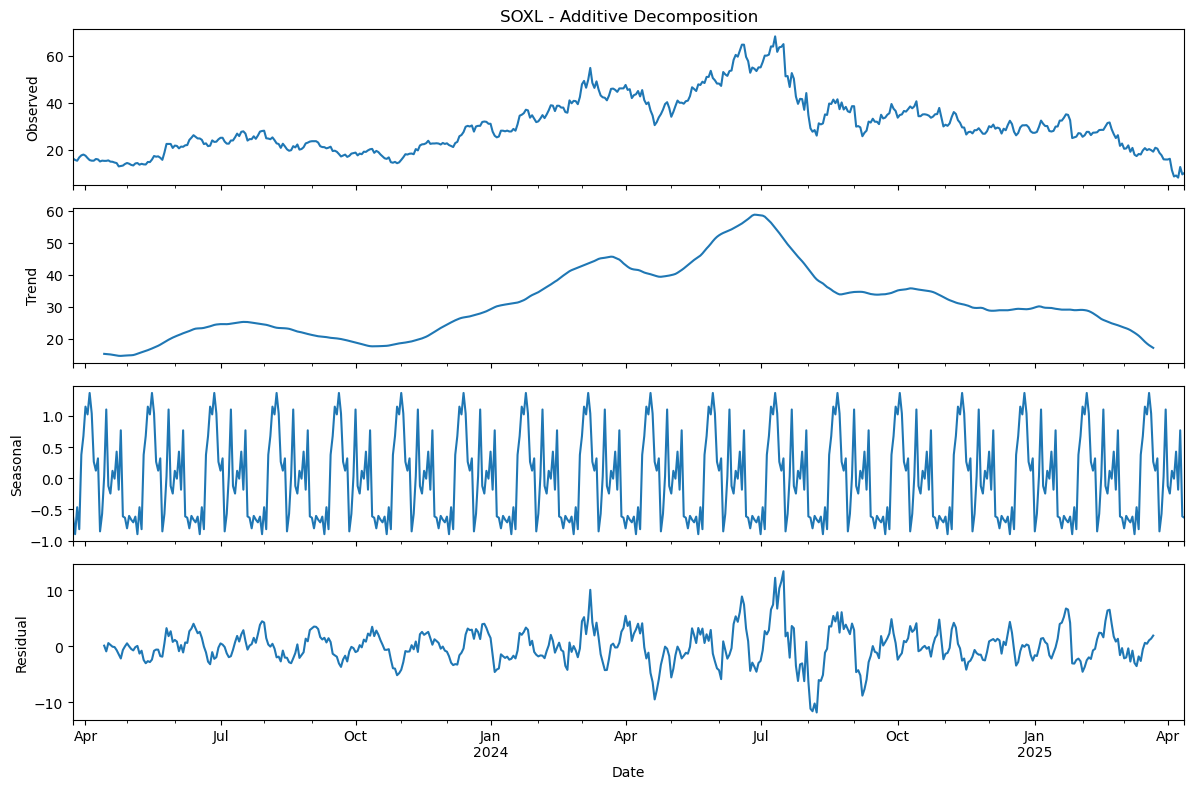


--- Multiplicative Decomposition for SOXL (Period=30) ---


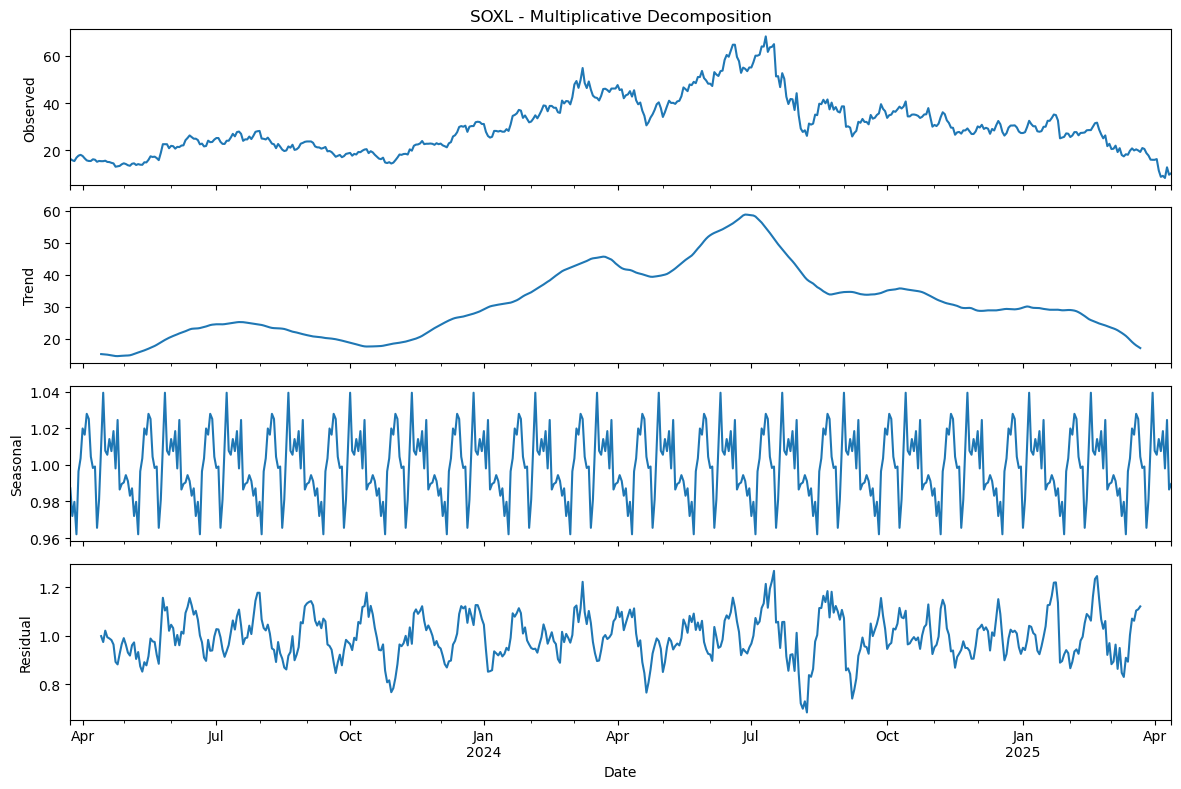


===== Stationarity & Decomposition for: TD_BANK =====

--- ADF Test for TD_BANK (Original) ---
ADF Statistic: -3.6784
p-value: 0.0044
Critical Values:
	1%: -3.4427
	5%: -2.8670
	10%: -2.5697
Conclusion: p-value is less than 0.05. The TD_BANK (Original) is likely stationary.

--- Additive Decomposition for TD_BANK (Period=30) ---


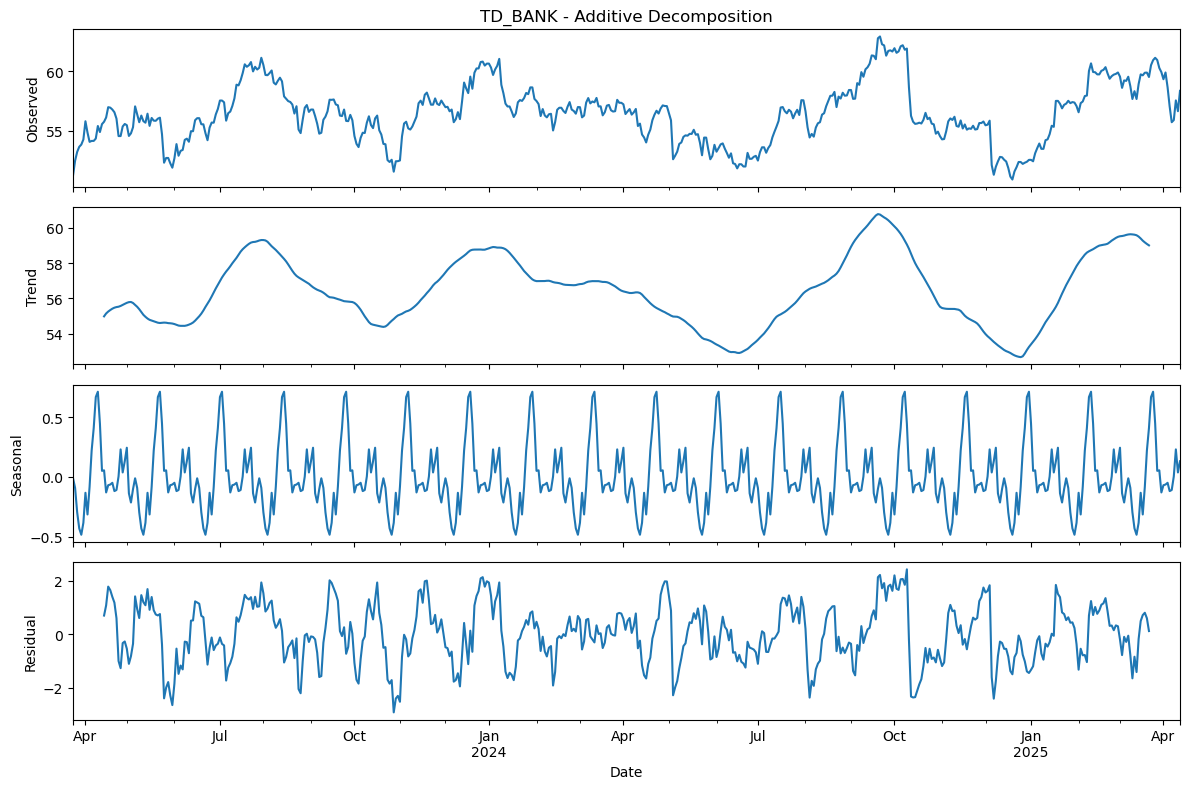


--- Multiplicative Decomposition for TD_BANK (Period=30) ---


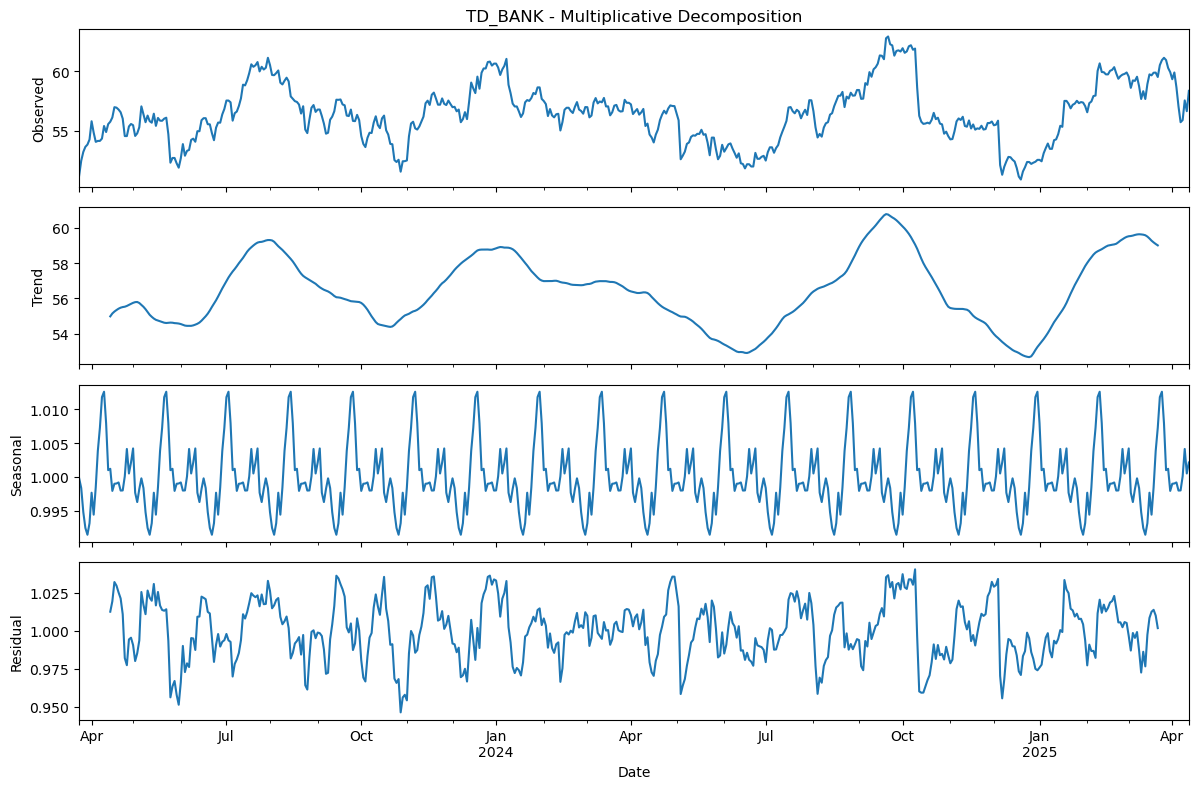


===== Stationarity & Decomposition for: NVDA =====

--- ADF Test for NVDA (Original) ---
ADF Statistic: -1.3587
p-value: 0.6019
Critical Values:
	1%: -3.4427
	5%: -2.8670
	10%: -2.5697
Conclusion: p-value is greater than 0.05. The NVDA (Original) is likely non-stationary.

--- ADF Test for NVDA (First Difference) ---
ADF Statistic: -25.8666
p-value: 0.0000
Critical Values:
	1%: -3.4427
	5%: -2.8670
	10%: -2.5697
Conclusion: p-value is less than 0.05. The NVDA (First Difference) is likely stationary.

--- Additive Decomposition for NVDA (Period=30) ---


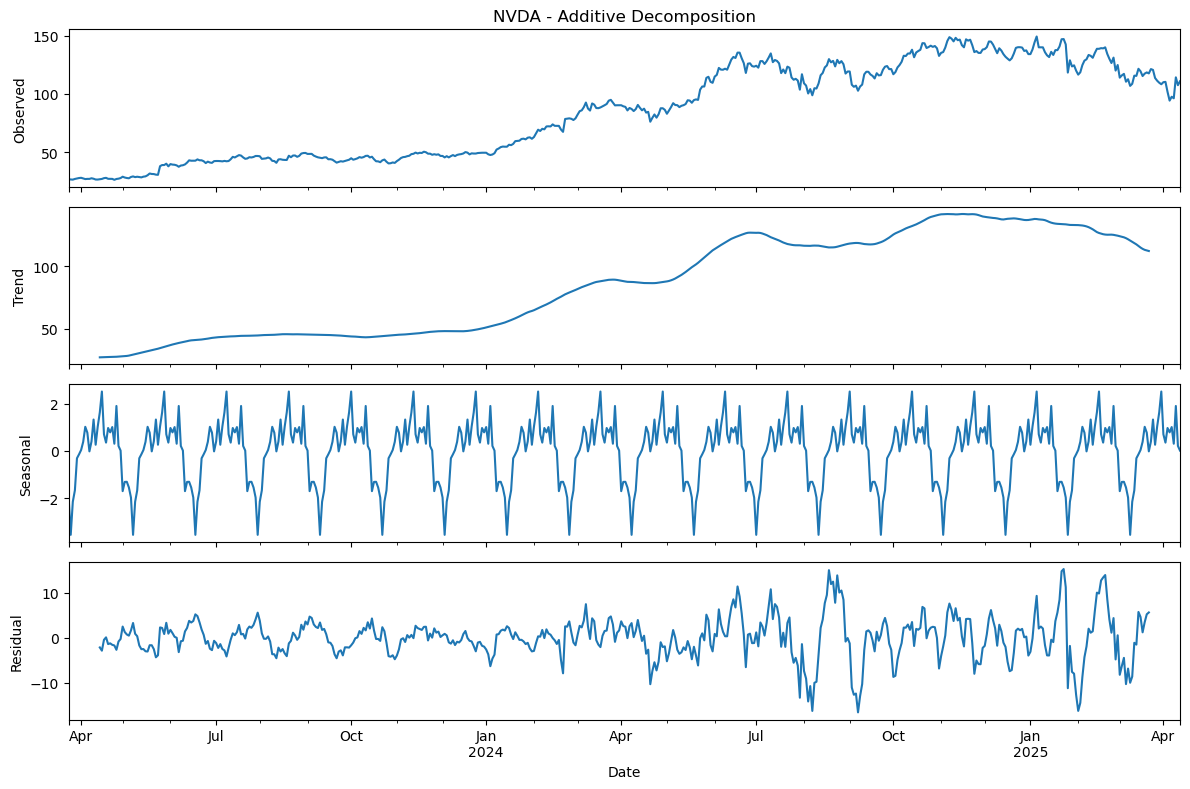


--- Multiplicative Decomposition for NVDA (Period=30) ---


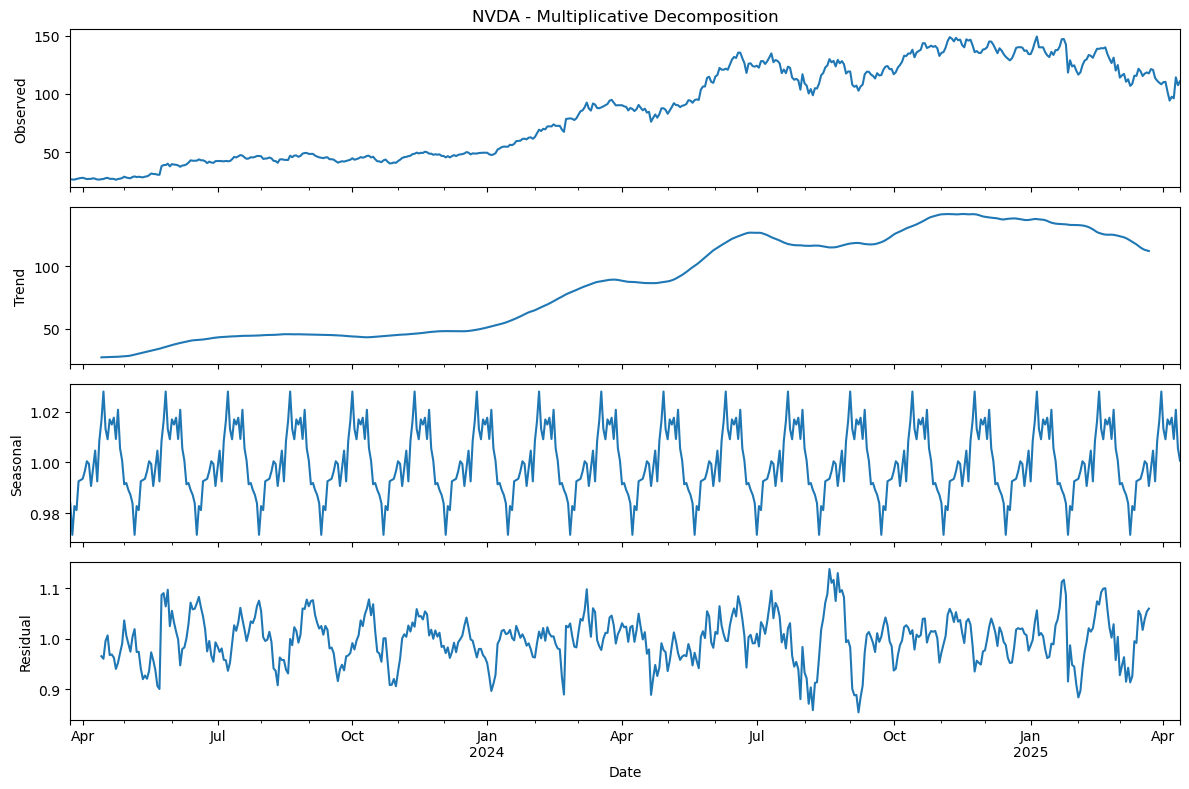


===== Stationarity & Decomposition for: MANULIFE =====

--- ADF Test for MANULIFE (Original) ---
ADF Statistic: 0.9872
p-value: 0.9941
Critical Values:
	1%: -3.4430
	5%: -2.8671
	10%: -2.5697
Conclusion: p-value is greater than 0.05. The MANULIFE (Original) is likely non-stationary.

--- ADF Test for MANULIFE (First Difference) ---
ADF Statistic: -6.1239
p-value: 0.0000
Critical Values:
	1%: -3.4430
	5%: -2.8671
	10%: -2.5697
Conclusion: p-value is less than 0.05. The MANULIFE (First Difference) is likely stationary.

--- Additive Decomposition for MANULIFE (Period=30) ---


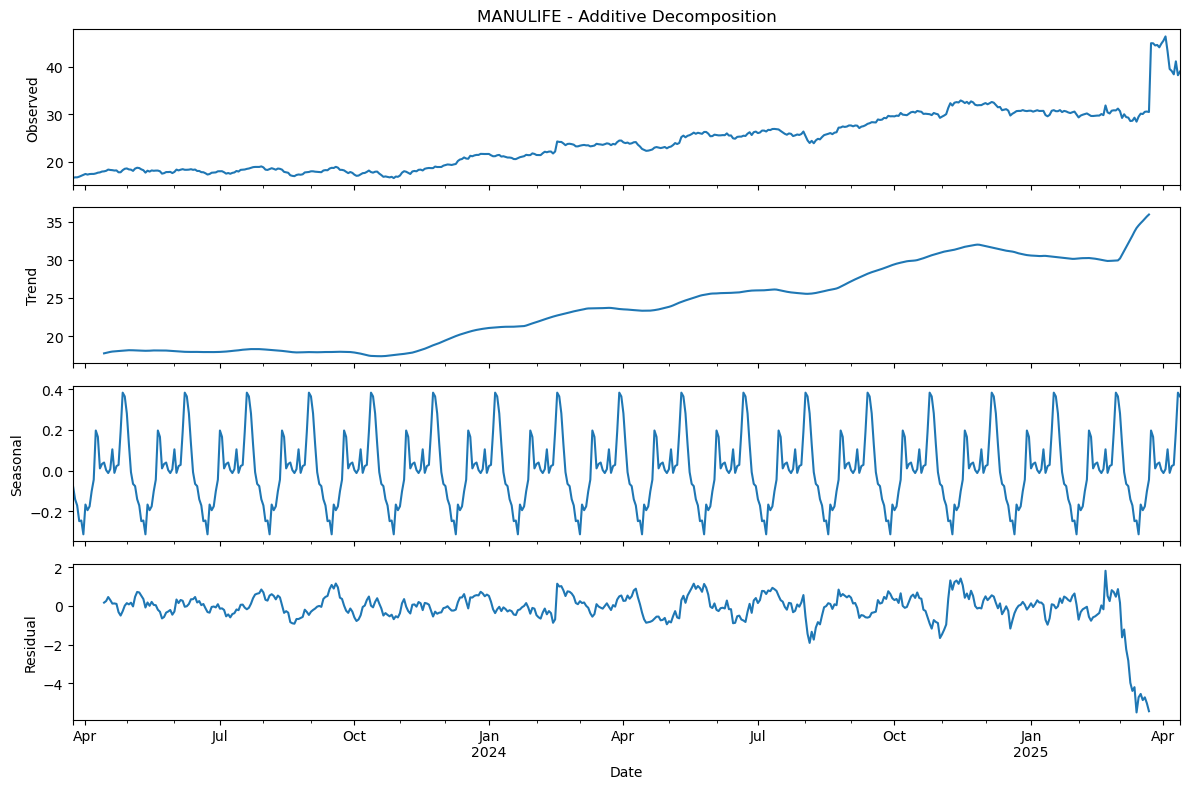


--- Multiplicative Decomposition for MANULIFE (Period=30) ---


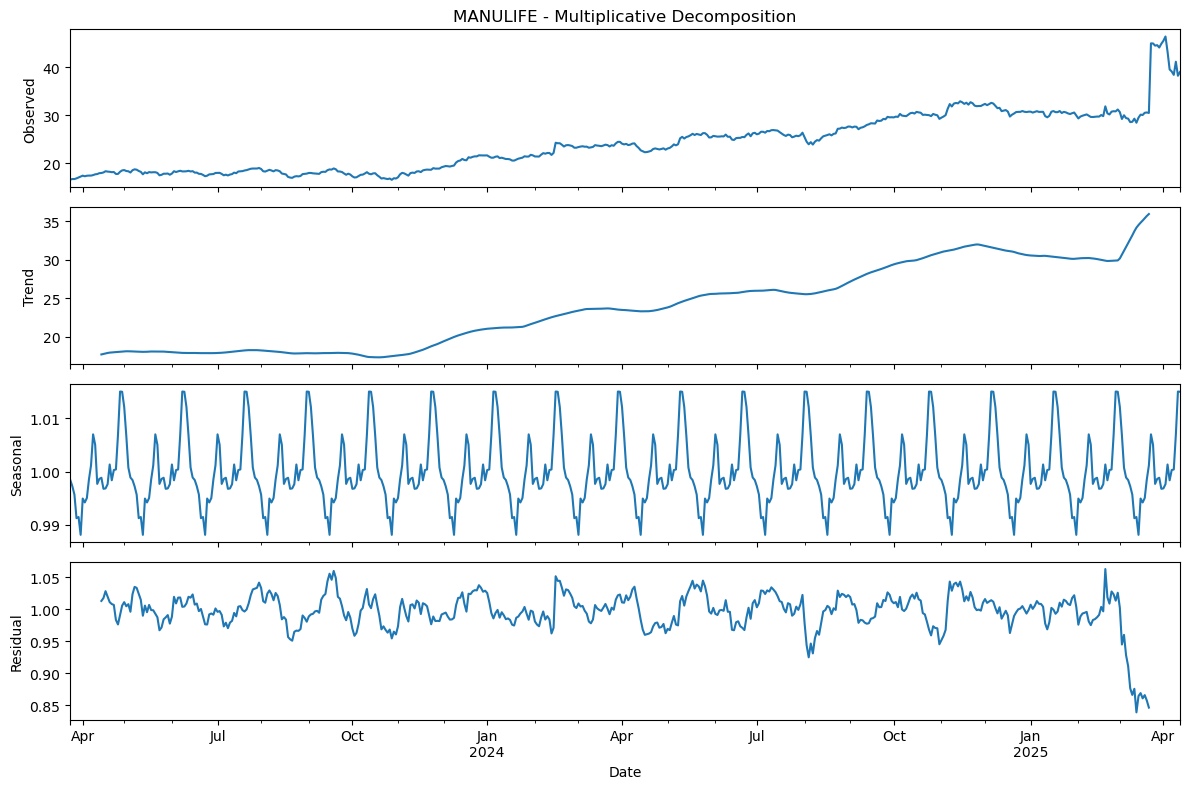

In [25]:
decomposed_data = {}

for sheet, ts in all_ts_data.items():
    print(f"\n===== Stationarity & Decomposition for: {sheet} =====")

    # Stationarity Check
    p_value_orig = perform_adf_test(ts, series_name=f"{sheet} (Original)")
    if p_value_orig > 0.05:
        # Check differenced series if original is non-stationary
        ts_diff = ts.diff().dropna()
        if not ts_diff.empty:
             _ = perform_adf_test(ts_diff, series_name=f"{sheet} (First Difference)")
        else:
            print("Differenced series is empty, cannot perform ADF test.")

    # Decomposition
    # Ensure series is long enough for the chosen period
    if len(ts.dropna()) > 2 * DECOMP_PERIOD:
        plot_decomposition(ts, model_type='additive', period=DECOMP_PERIOD, series_name=sheet)
        plot_decomposition(ts, model_type='multiplicative', period=DECOMP_PERIOD, series_name=sheet)
        # Store decomposition results if needed later (optional)
        # decomposed_data[sheet] = {
        #     'additive': seasonal_decompose(ts.dropna(), model='additive', period=DECOMP_PERIOD),
        #     'multiplicative': seasonal_decompose(ts.dropna(), model='multiplicative', period=DECOMP_PERIOD)
        # }
    else:
        print(f"Skipping decomposition for {sheet}: Series length ({len(ts.dropna())}) is not sufficient for period {DECOMP_PERIOD}.")

### 7. Forecasting Models & Performance Evaluation Loop


===== Forecasting Models for: MARA =====
Train size: 428, Test size: 108

Fitting ARIMA...
Using fixed ARIMA order: (5, 1, 1)

--- Evaluation Metrics for ARIMA ---
RMSE: 7.5131
MAE:  6.5799
MAPE: 44.50%
MSE:  56.4472


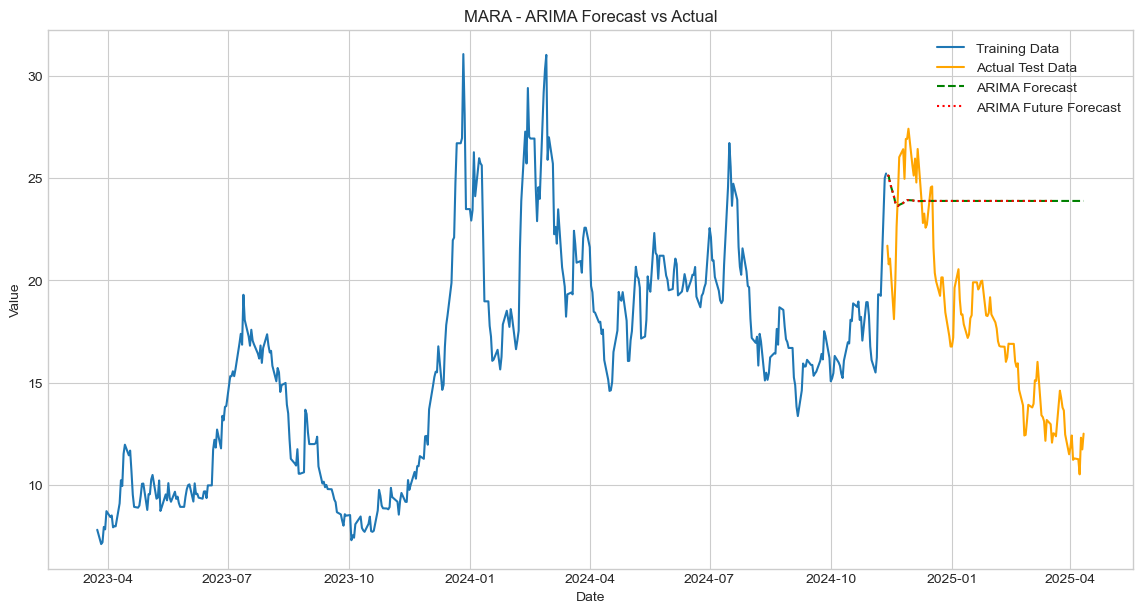


Fitting ETS...
Using ETS parameters: trend=add, seasonal=None

--- Evaluation Metrics for ETS ---
RMSE: 11.1368
MAE:  9.7474
MAPE: 65.94%
MSE:  124.0280


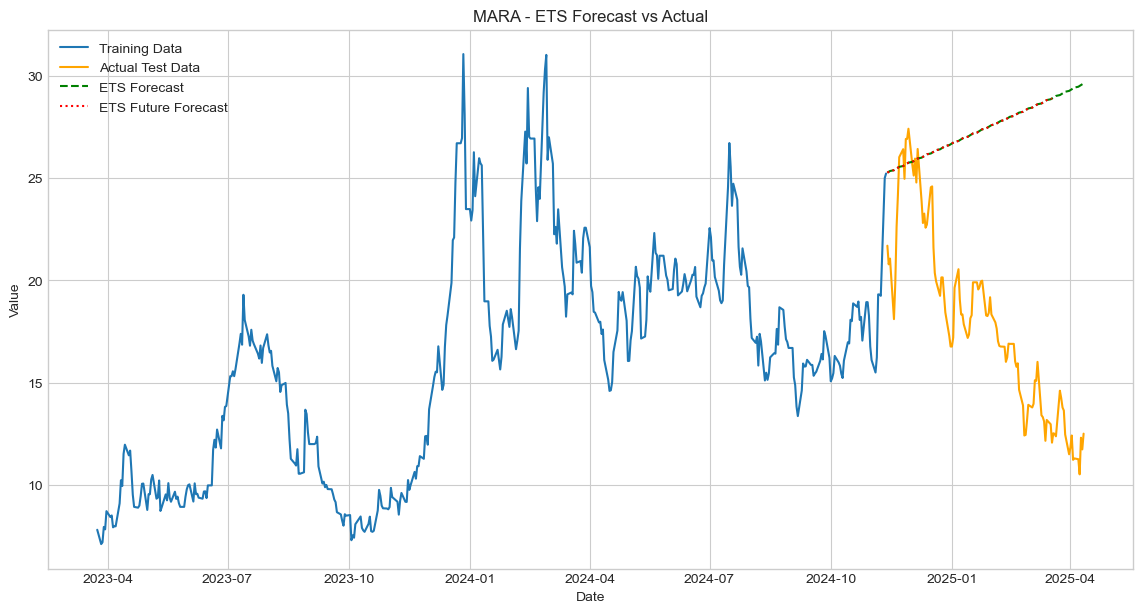

01:27:53 - cmdstanpy - INFO - Chain [1] start processing
01:27:53 - cmdstanpy - INFO - Chain [1] done processing



Fitting Prophet...

--- Evaluation Metrics for Prophet ---
RMSE: 4.1807
MAE:  3.3039
MAPE: 17.81%
MSE:  17.4783


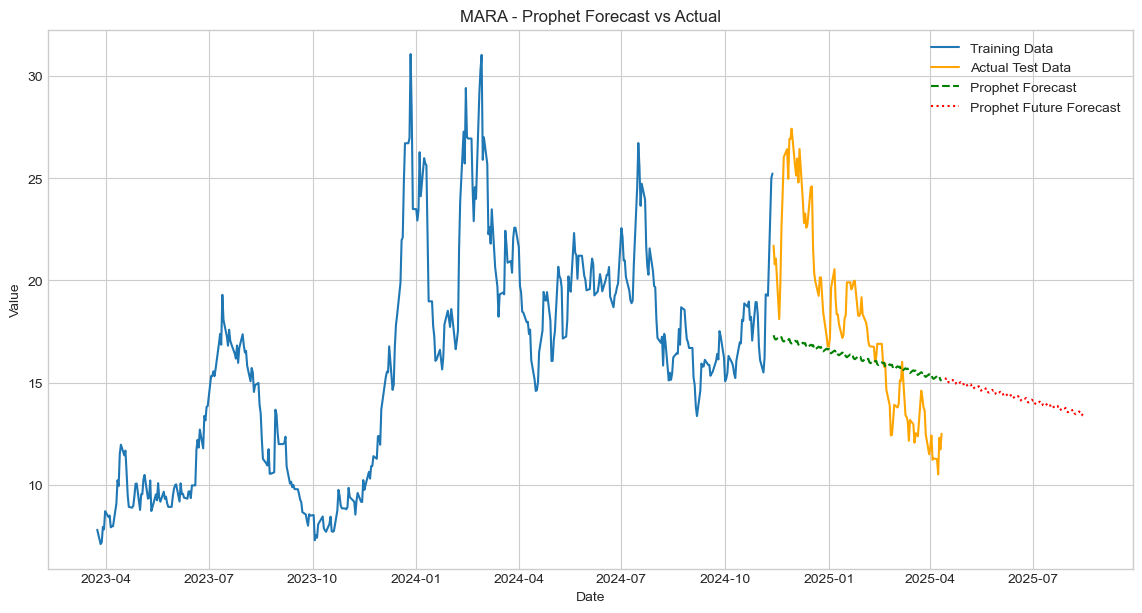


Fitting LSTM...


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_53 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTM training complete.

--- Evaluation Metrics for LSTM ---
RMSE: 4.0713
MAE:  3.3741
MAPE: 21.18%
MSE:  16.5755


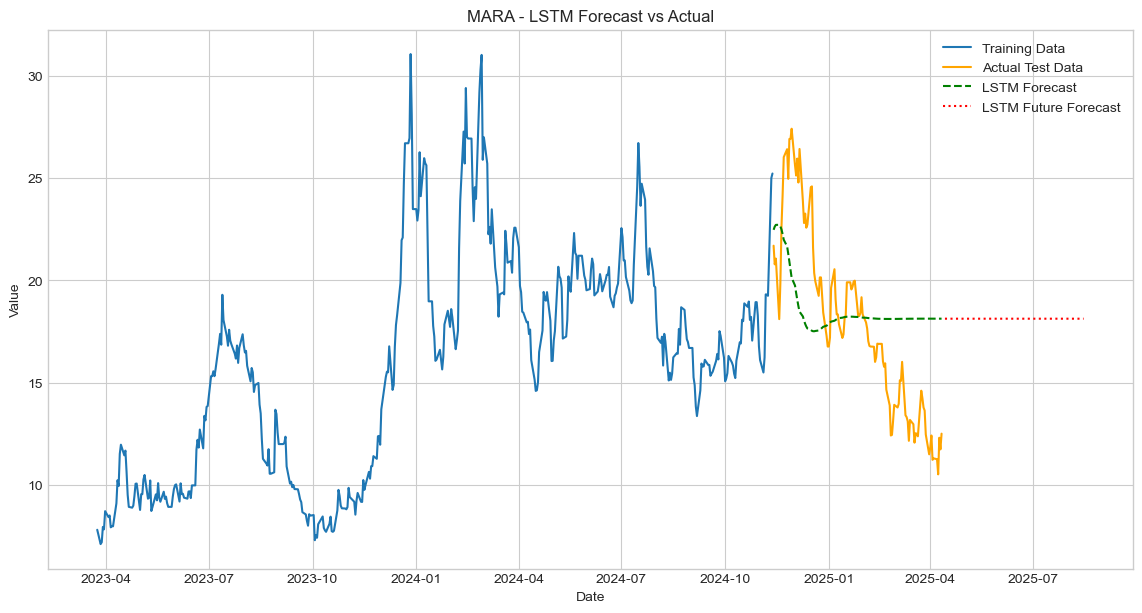


===== Forecasting Models for: SOXL =====
Train size: 428, Test size: 108

Fitting ARIMA...
Using fixed ARIMA order: (5, 1, 1)

--- Evaluation Metrics for ARIMA ---
RMSE: 8.5831
MAE:  6.3369
MAPE: 36.99%
MSE:  73.6695


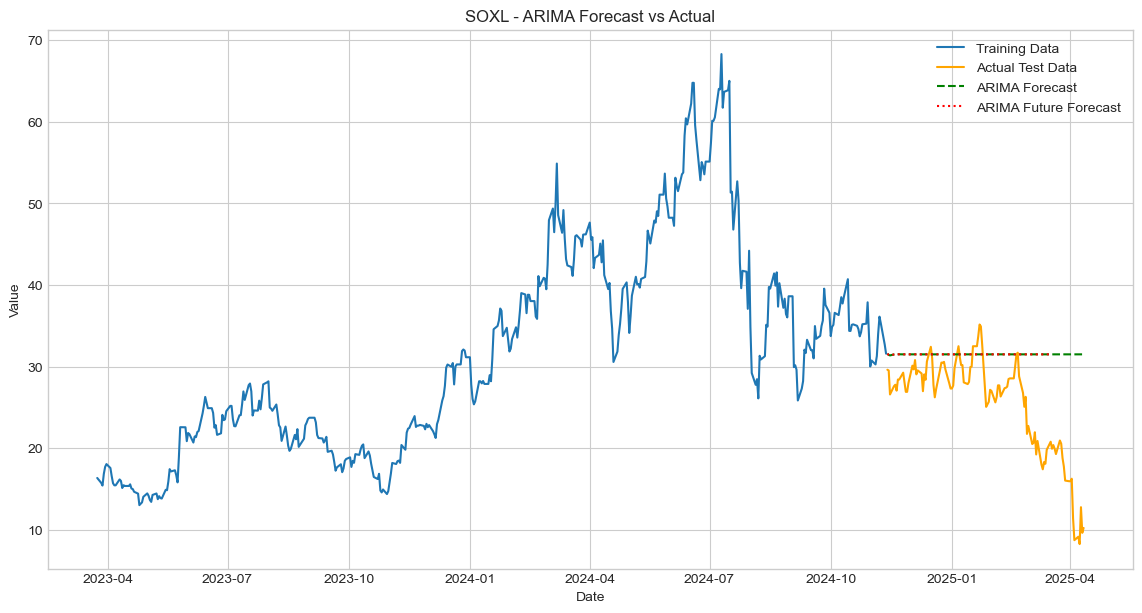


Fitting ETS...
Using ETS parameters: trend=add, seasonal=None

--- Evaluation Metrics for ETS ---
RMSE: 10.7614
MAE:  8.2731
MAPE: 46.98%
MSE:  115.8067


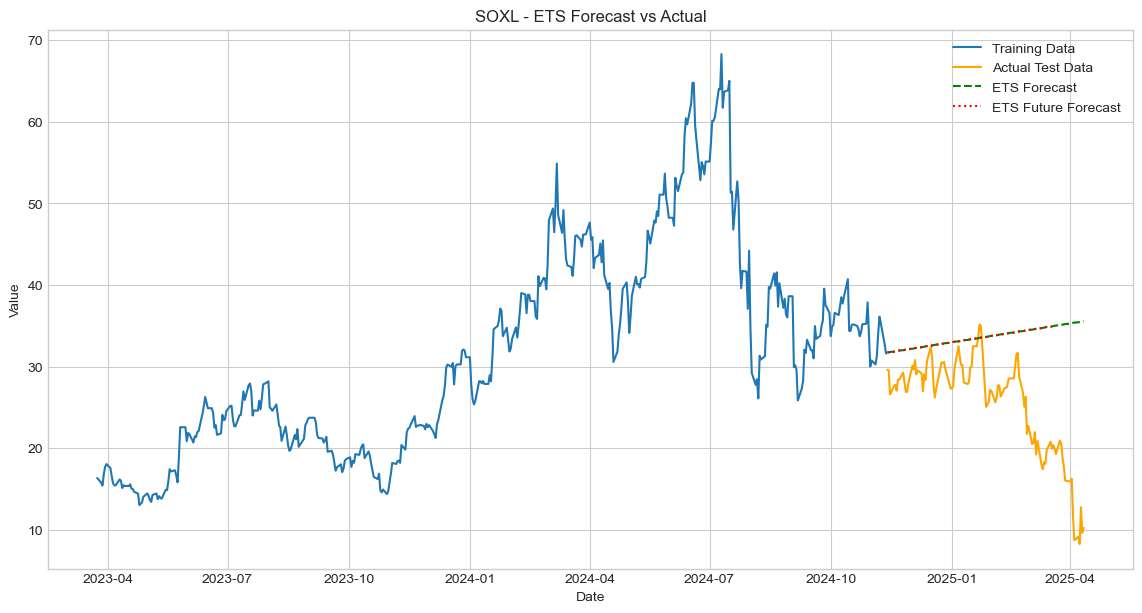

01:28:24 - cmdstanpy - INFO - Chain [1] start processing
01:28:24 - cmdstanpy - INFO - Chain [1] done processing



Fitting Prophet...

--- Evaluation Metrics for Prophet ---
RMSE: 8.4127
MAE:  7.2534
MAPE: 29.03%
MSE:  70.7737


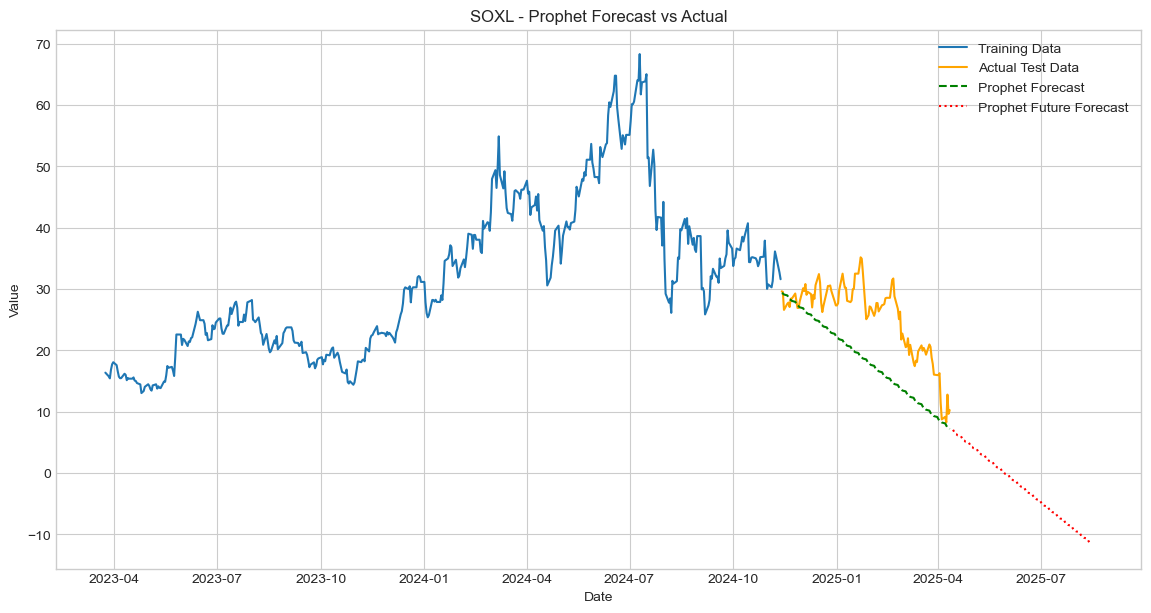


Fitting LSTM...


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTM training complete.

--- Evaluation Metrics for LSTM ---
RMSE: 27.6561
MAE:  24.4948
MAPE: 123.70%
MSE:  764.8594


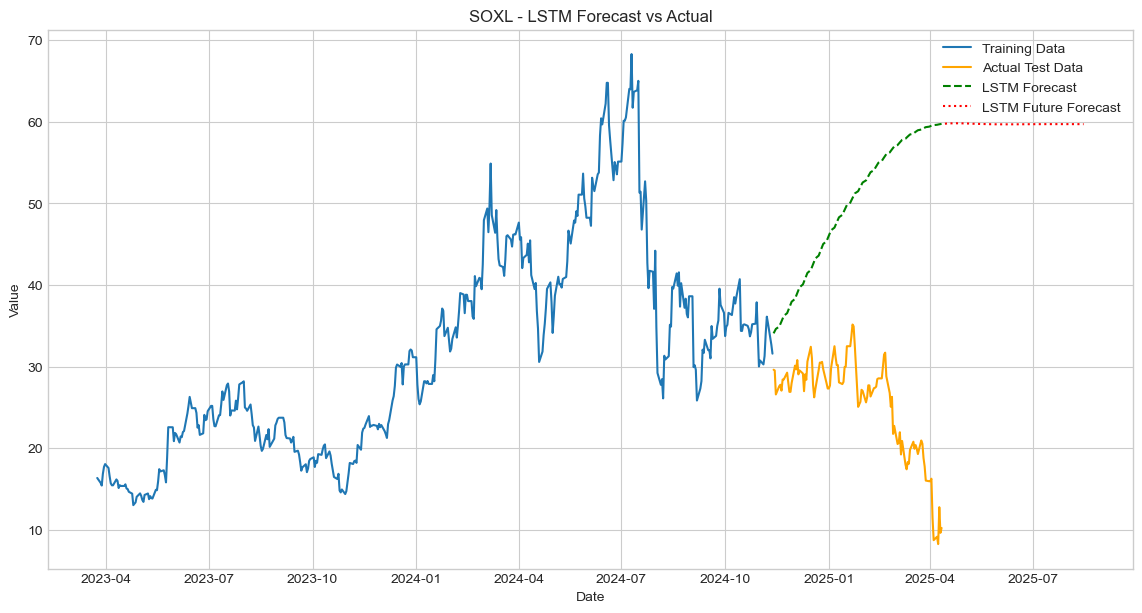


===== Forecasting Models for: TD_BANK =====
Train size: 428, Test size: 108

Fitting ARIMA...
Using fixed ARIMA order: (5, 1, 1)

--- Evaluation Metrics for ARIMA ---
RMSE: 3.2047
MAE:  2.7504
MAPE: 4.80%
MSE:  10.2700


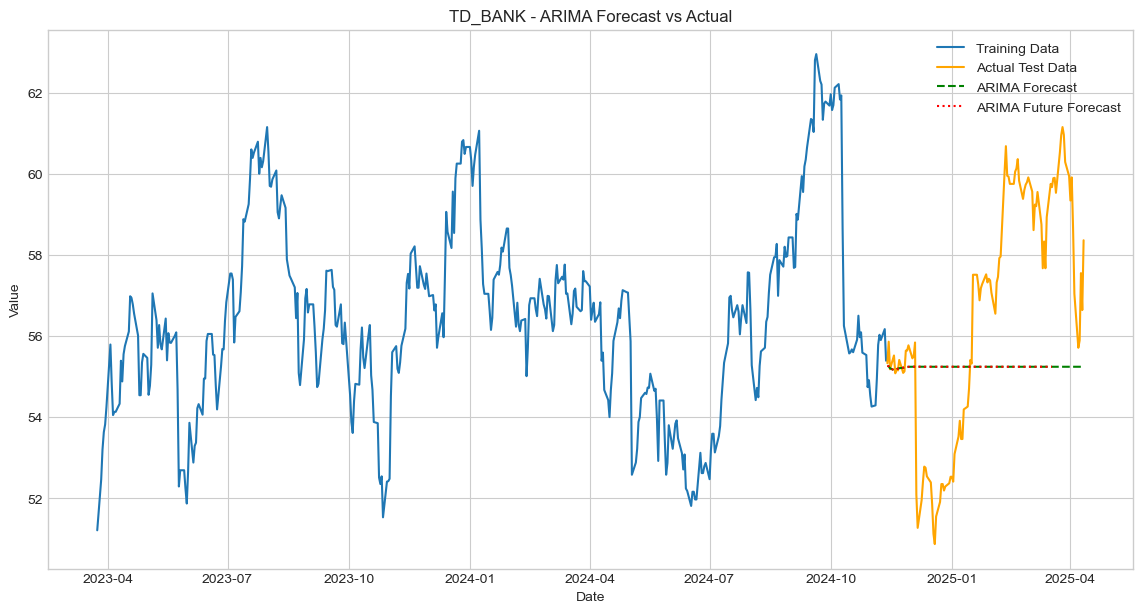


Fitting ETS...
Using ETS parameters: trend=add, seasonal=None

--- Evaluation Metrics for ETS ---
RMSE: 2.7772
MAE:  2.3812
MAPE: 4.20%
MSE:  7.7127


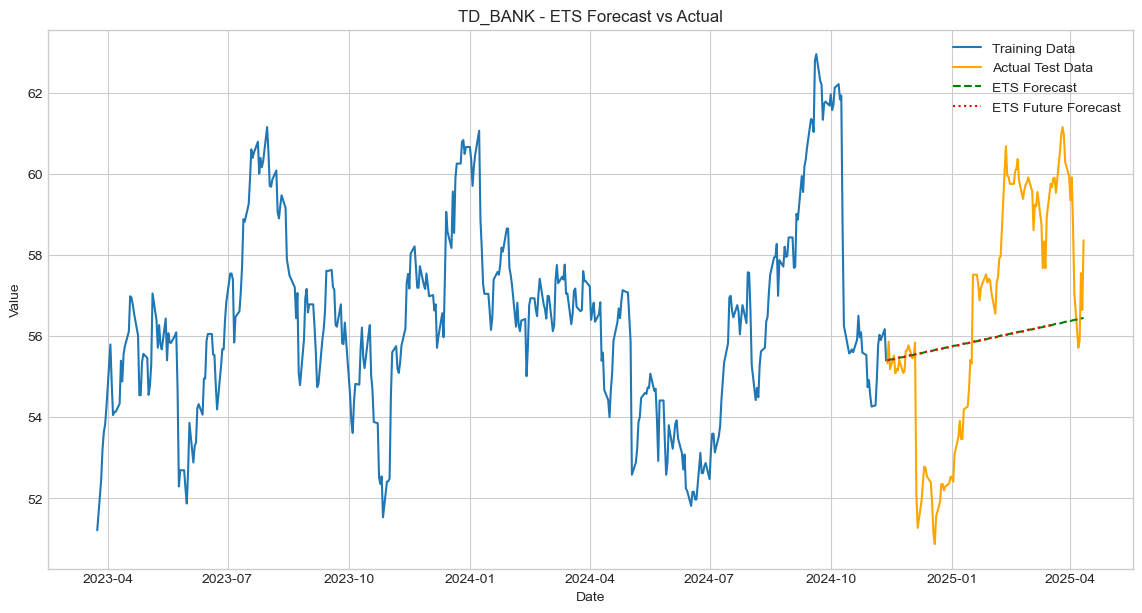

01:28:54 - cmdstanpy - INFO - Chain [1] start processing
01:28:54 - cmdstanpy - INFO - Chain [1] done processing



Fitting Prophet...

--- Evaluation Metrics for Prophet ---
RMSE: 5.3269
MAE:  4.8824
MAPE: 8.84%
MSE:  28.3760


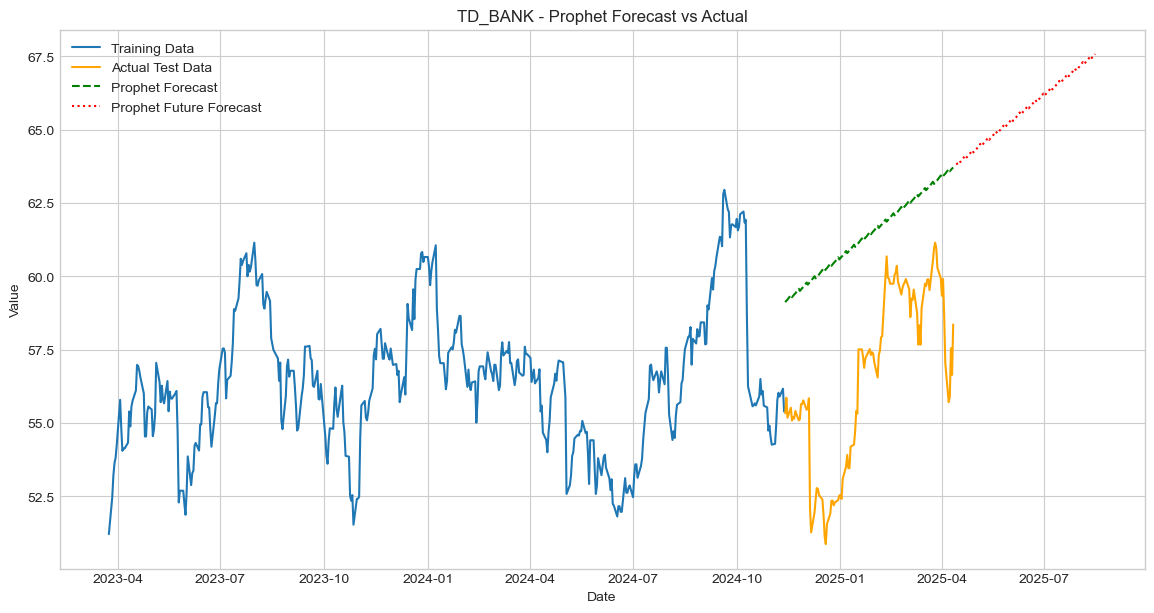


Fitting LSTM...


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_55 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTM training complete.

--- Evaluation Metrics for LSTM ---
RMSE: 2.9610
MAE:  2.4562
MAPE: 4.42%
MSE:  8.7675


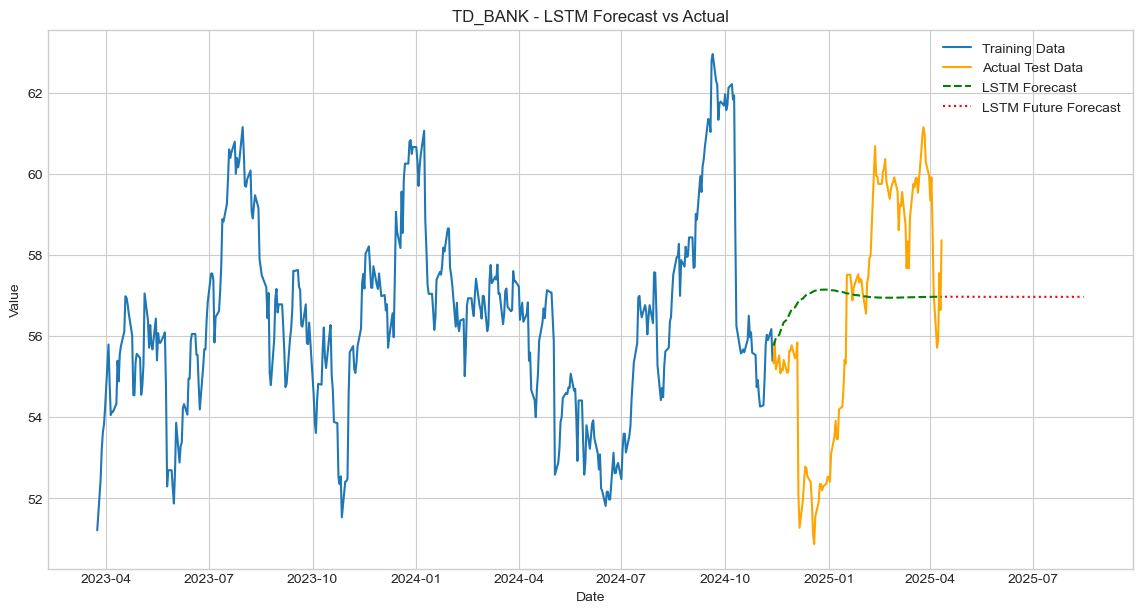


===== Forecasting Models for: NVDA =====
Train size: 428, Test size: 108

Fitting ARIMA...
Using fixed ARIMA order: (5, 1, 1)

--- Evaluation Metrics for ARIMA ---
RMSE: 22.4653
MAE:  18.3824
MAPE: 15.48%
MSE:  504.6888


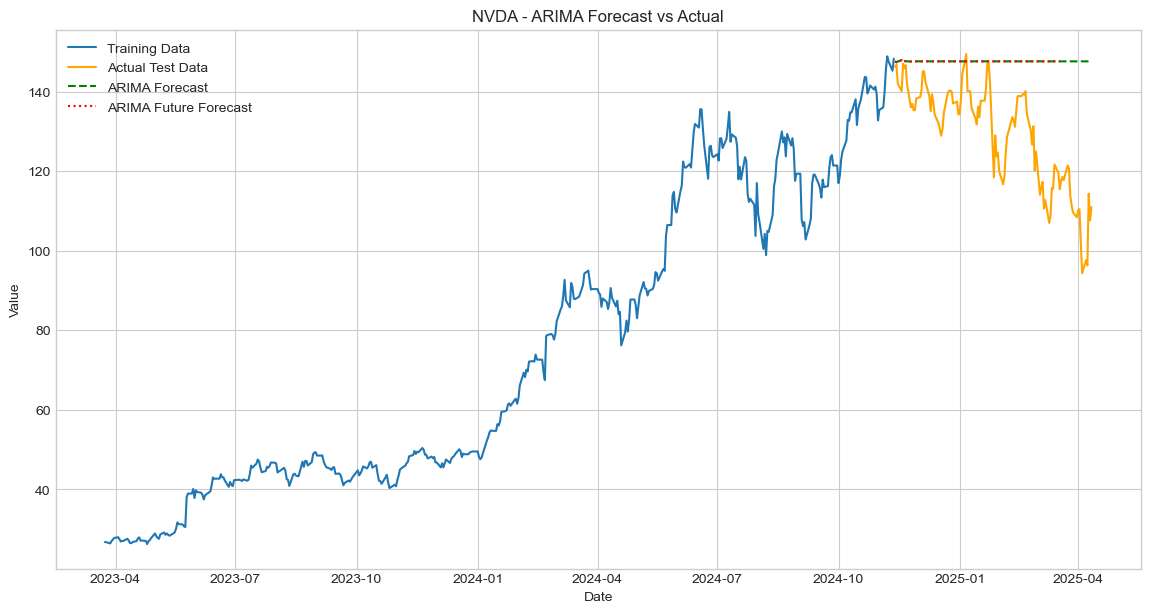


Fitting ETS...
Using ETS parameters: trend=add, seasonal=None

--- Evaluation Metrics for ETS ---
RMSE: 40.1309
MAE:  34.2999
MAPE: 28.54%
MSE:  1610.4925


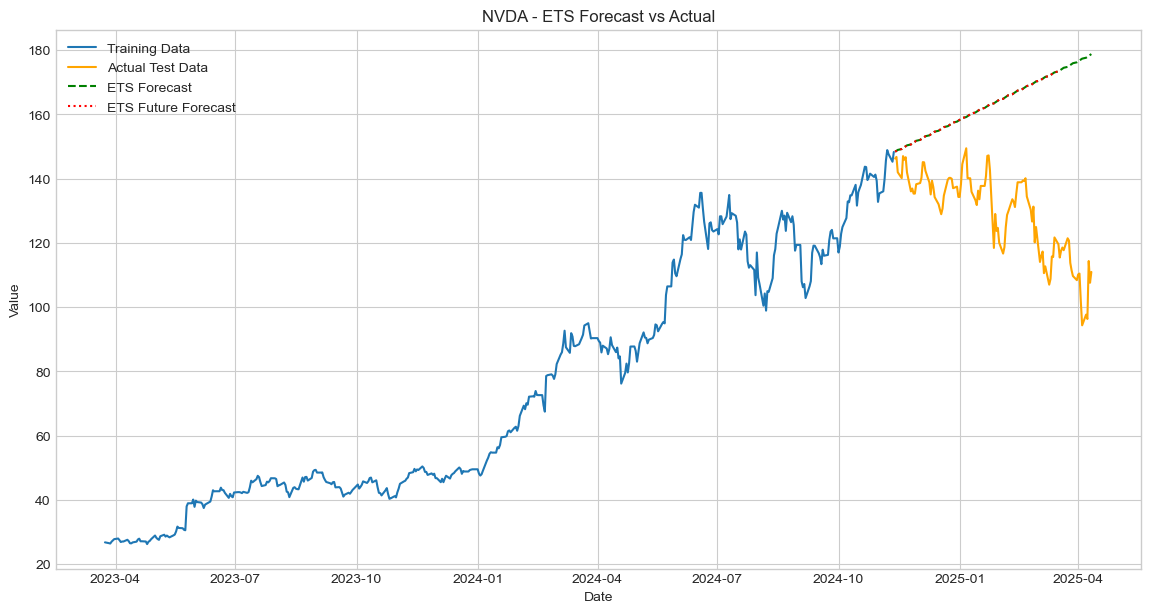

01:29:25 - cmdstanpy - INFO - Chain [1] start processing
01:29:25 - cmdstanpy - INFO - Chain [1] done processing



Fitting Prophet...

--- Evaluation Metrics for Prophet ---
RMSE: 25.5532
MAE:  19.2010
MAPE: 16.41%
MSE:  652.9639


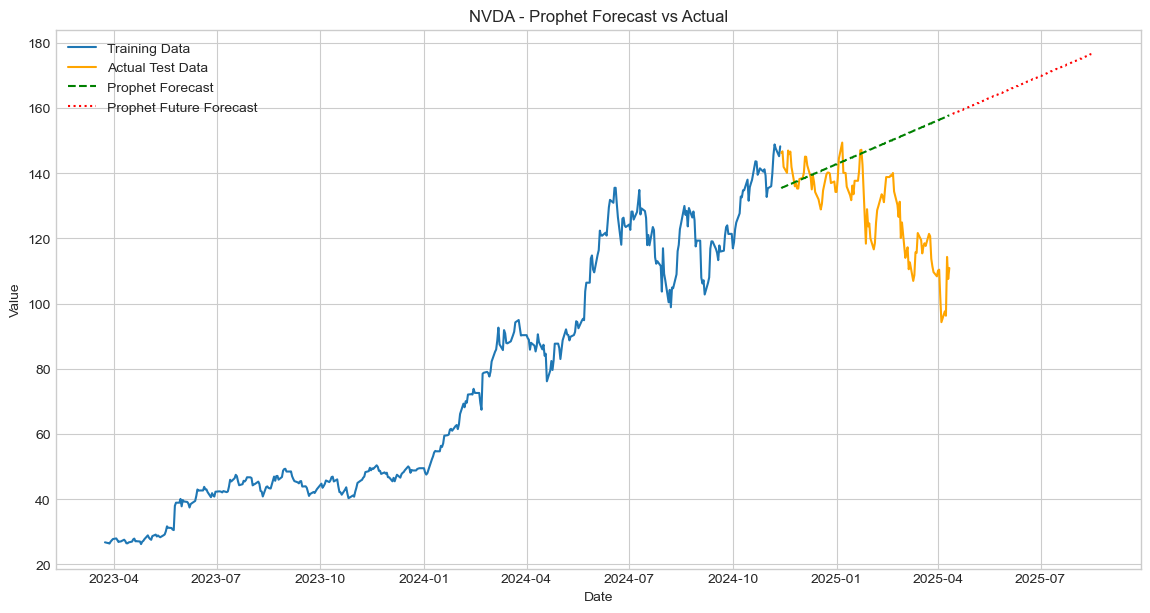


Fitting LSTM...


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_56 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTM training complete.

--- Evaluation Metrics for LSTM ---
RMSE: 150.1211
MAE:  122.7579
MAPE: 96.80%
MSE:  22536.3511


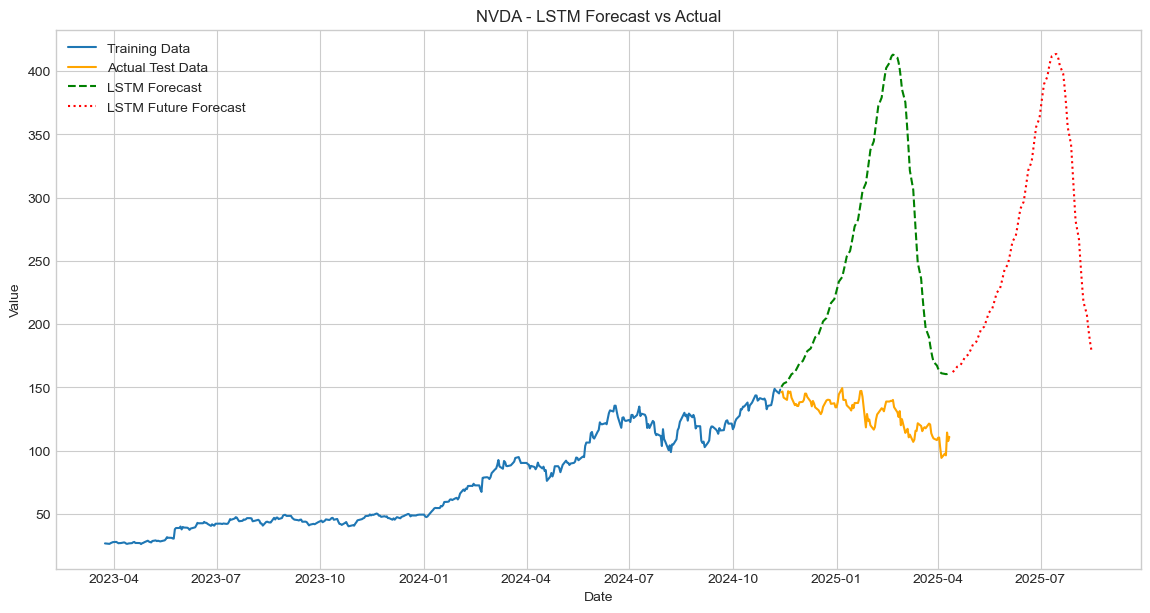


===== Forecasting Models for: MANULIFE =====
Train size: 428, Test size: 108

Fitting ARIMA...
Using fixed ARIMA order: (5, 1, 1)

--- Evaluation Metrics for ARIMA ---
RMSE: 4.3407
MAE:  2.9239
MAPE: 8.30%
MSE:  18.8420


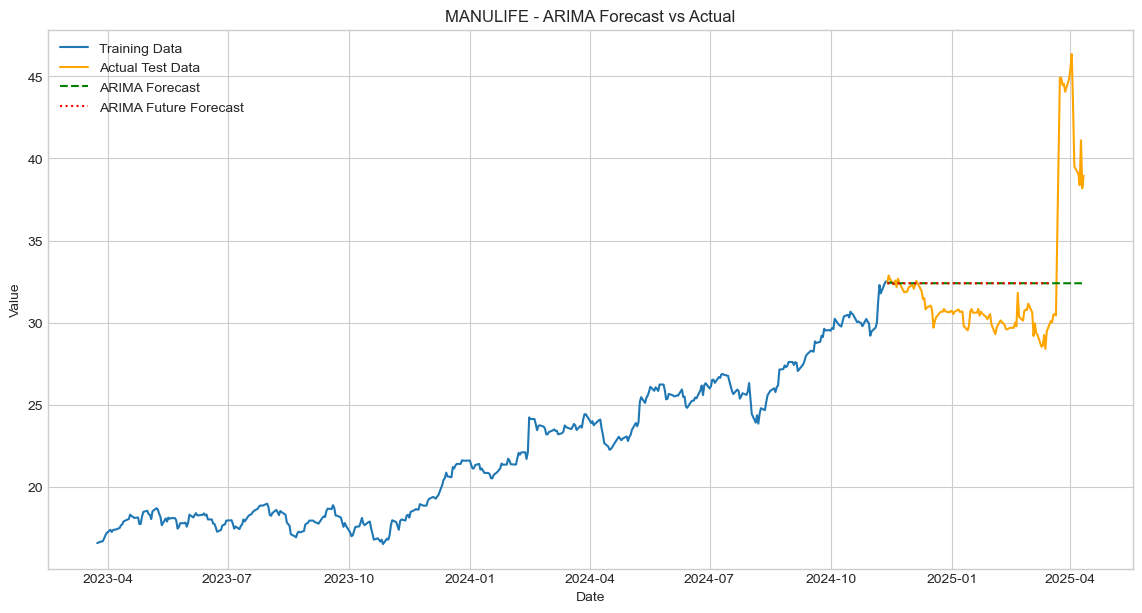


Fitting ETS...
Using ETS parameters: trend=add, seasonal=None

--- Evaluation Metrics for ETS ---
RMSE: 4.5759
MAE:  3.9742
MAPE: 12.29%
MSE:  20.9386


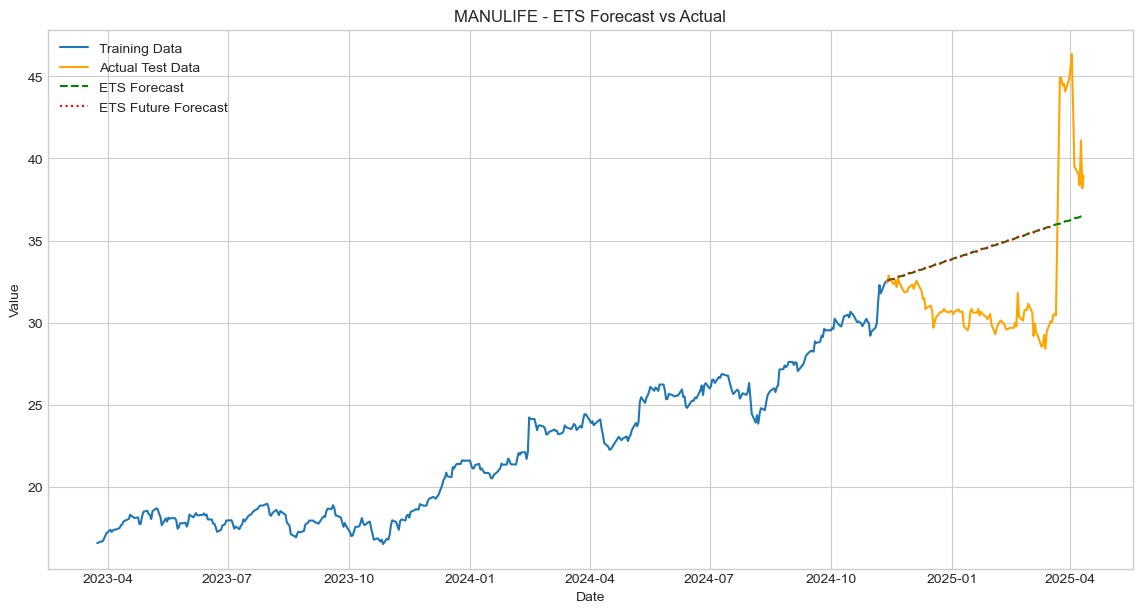

01:29:56 - cmdstanpy - INFO - Chain [1] start processing
01:29:56 - cmdstanpy - INFO - Chain [1] done processing



Fitting Prophet...

--- Evaluation Metrics for Prophet ---
RMSE: 4.3565
MAE:  3.6844
MAPE: 11.42%
MSE:  18.9790


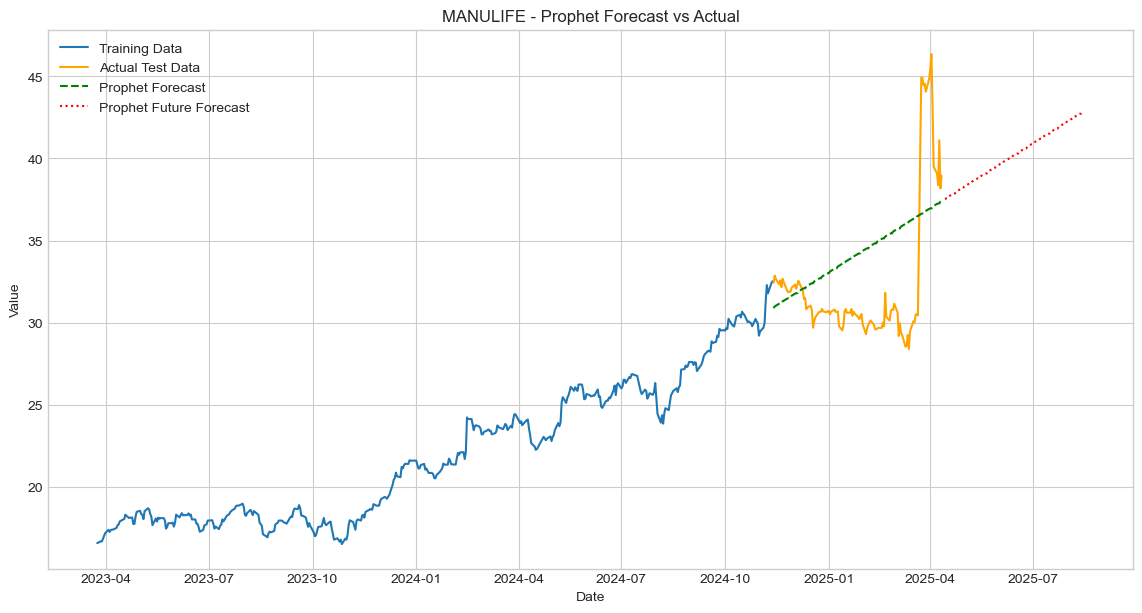


Fitting LSTM...


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_57 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None
LSTM training complete.

--- Evaluation Metrics for LSTM ---
RMSE: 126636272462.8965
MAE:  29416787068.1552
MAPE: 74196361637.03%
MSE:  16036745503296960069632.0000


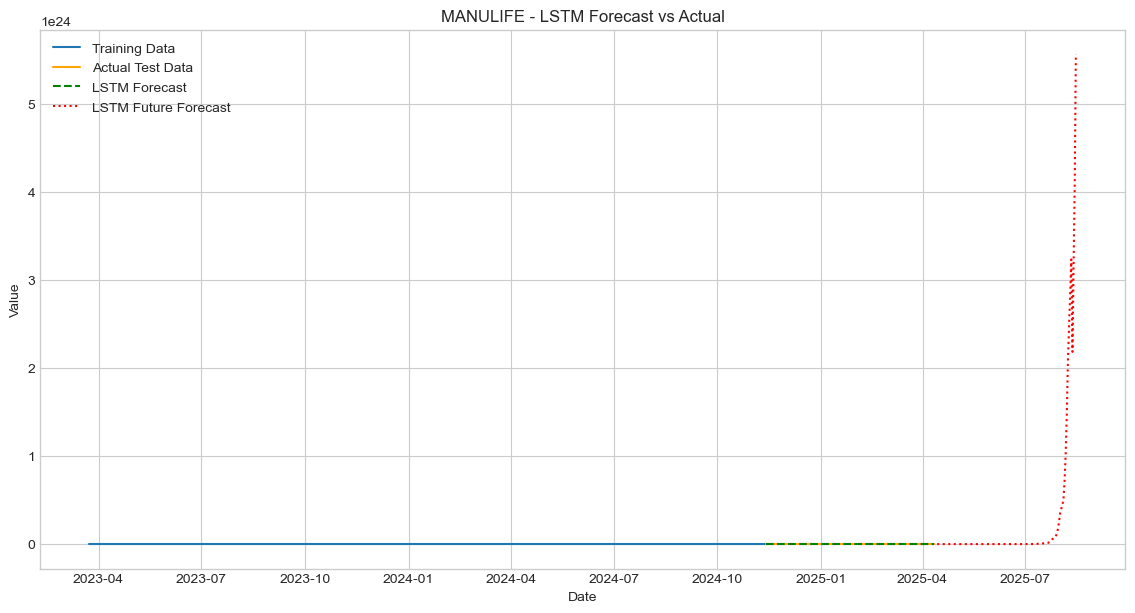

In [75]:
all_results = {}

for sheet, ts in all_ts_data.items():
    print(f"\n===== Forecasting Models for: {sheet} =====")
    results = {'Metrics': {}, 'Forecasts': {}}

    # Ensure enough data for split
    if len(ts) < LSTM_LOOK_BACK + int(1/TEST_SIZE): # Need enough for lookback + test set
         print(f"Skipping {sheet}: Not enough data for train/test split and LSTM lookback ({len(ts)} points).")
         continue

    # Split data
    train_size = int(len(ts) * (1 - TEST_SIZE))
    train, test = ts[:train_size], ts[train_size:]
    print(f"Train size: {len(train)}, Test size: {len(test)}")

    # --- Model Fitting & Prediction ---

    # 1. ARIMA
    try:
        print("\nFitting ARIMA...")
        # Optional: Use auto_arima to find best order
        # auto_model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')
        # print(f"Auto ARIMA selected order: {auto_model.order}")
        # arima_model = ARIMA(train, order=auto_model.order).fit()
        # --- Using fixed order for demonstration ---
        print(f"Using fixed ARIMA order: {ARIMA_ORDER}")
        arima_model = ARIMA(train, order=ARIMA_ORDER).fit()
        arima_forecast = arima_model.predict(start=test.index[0], end=test.index[-1])
        # Extend forecast
        arima_future_steps = len(pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=FORECAST_HORIZON_EXTENDED, freq=FREQ))
        arima_future_forecast = arima_model.forecast(steps=arima_future_steps)
        results['Forecasts']['ARIMA'] = {'test': arima_forecast, 'future': arima_future_forecast}
        results['Metrics']['ARIMA'] = evaluate_forecast(test, arima_forecast, model_name="ARIMA")
        plot_forecast(train, test, arima_forecast,
                      future_forecast_dates=arima_future_forecast.index,
                      future_forecast_values=arima_future_forecast,
                      model_name="ARIMA", series_name=sheet)

    except Exception as e:
        print(f"ARIMA failed for {sheet}: {e}")
        results['Forecasts']['ARIMA'] = None
        results['Metrics']['ARIMA'] = None

    # 2. Exponential Smoothing (ETS)
    try:
        print("\nFitting ETS...")
        print(f"Using ETS parameters: trend={ETS_TREND}, seasonal={ETS_SEASONAL}")
        ets_model = ExponentialSmoothing(train,
                                         trend=ETS_TREND,
                                         seasonal=ETS_SEASONAL,
                                         seasonal_periods=ETS_SEASONAL_PERIODS,
                                         initialization_method='estimated').fit() # Use 'heuristic' or others if 'estimated' fails
        ets_forecast = ets_model.predict(start=test.index[0], end=test.index[-1])
        # Extend forecast
        ets_future_steps = len(pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=FORECAST_HORIZON_EXTENDED, freq=FREQ))
        ets_future_forecast = ets_model.forecast(steps=ets_future_steps)

        results['Forecasts']['ETS'] = {'test': ets_forecast, 'future': ets_future_forecast}
        results['Metrics']['ETS'] = evaluate_forecast(test, ets_forecast, model_name="ETS")
        plot_forecast(train, test, ets_forecast,
                      future_forecast_dates=ets_future_forecast.index,
                      future_forecast_values=ets_future_forecast,
                      model_name="ETS", series_name=sheet)

    except Exception as e:
        print(f"ETS failed for {sheet}: {e}")
        results['Forecasts']['ETS'] = None
        results['Metrics']['ETS'] = None


    # 3. Prophet
    try:
        print("\nFitting Prophet...")
        prophet_train_df = train.reset_index().rename(columns={DATE_COLUMN: 'ds', TARGET_COLUMN: 'y'})
        # Prophet tuning parameters (examples):
        prophet_model = Prophet(
            daily_seasonality='auto', # Let Prophet detect
            weekly_seasonality='auto',
            yearly_seasonality='auto',
            # changepoint_prior_scale=0.05, # Default 0.05. Increase for more flexibility, decrease for less.
            # seasonality_prior_scale=10.0, # Default 10.0. Controls flexibility of seasonality.
            # holidays=None # Optional: pd.DataFrame with holiday info
        )
        prophet_model.fit(prophet_train_df)

        # Create future dataframe for prediction (includes test period + future horizon)
        future_df = prophet_model.make_future_dataframe(periods=len(test) + FORECAST_HORIZON_EXTENDED, freq=FREQ)
        prophet_forecast_df = prophet_model.predict(future_df)

        # Extract test forecast and future forecast
        prophet_forecast = prophet_forecast_df['yhat'].iloc[len(train):len(train)+len(test)].values
        prophet_future_forecast = prophet_forecast_df['yhat'].iloc[-FORECAST_HORIZON_EXTENDED:].values
        prophet_future_dates = prophet_forecast_df['ds'].iloc[-FORECAST_HORIZON_EXTENDED:]

        # Align forecast index with test index for evaluation and plotting
        prophet_forecast_series = pd.Series(prophet_forecast, index=test.index)

        results['Forecasts']['Prophet'] = {'test': prophet_forecast_series, 'future': pd.Series(prophet_future_forecast, index=prophet_future_dates)}
        results['Metrics']['Prophet'] = evaluate_forecast(test, prophet_forecast_series, model_name="Prophet")
        plot_forecast(train, test, prophet_forecast_series,
                      future_forecast_dates=prophet_future_dates,
                      future_forecast_values=prophet_future_forecast,
                      model_name="Prophet", series_name=sheet)
        # Optional: Plot Prophet components
        # fig_components = prophet_model.plot_components(prophet_forecast_df)
        # plt.show()

    except Exception as e:
        print(f"Prophet failed for {sheet}: {e}")
        results['Forecasts']['Prophet'] = None
        results['Metrics']['Prophet'] = None


    # 4. LSTM (Bonus)
    try:
        print("\nFitting LSTM...")
        # --- LSTM Data Preparation ---
        # Scale data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
        scaled_test = scaler.transform(test.values.reshape(-1, 1)) # Use transform only

        # Create sequences using TimeseriesGenerator
        train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=LSTM_LOOK_BACK, batch_size=LSTM_BATCH_SIZE)
        test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=LSTM_LOOK_BACK, batch_size=1) # Batch size 1 for prediction

        # --- LSTM Model Definition ---
        lstm_model = Sequential([
            LSTM(units=50, activation='relu', input_shape=(LSTM_LOOK_BACK, 1)), # Input shape: (look_back, num_features)
            Dense(units=1)
        ])
        lstm_model.compile(optimizer='adam', loss='mean_squared_error')
        print(lstm_model.summary())

        # --- LSTM Model Training ---
        # Need enough data for at least one batch in generator
        if len(train_generator) > 0:
            history = lstm_model.fit(train_generator, epochs=LSTM_EPOCHS, verbose=0) # verbose=0 to reduce output
            print("LSTM training complete.")
            # Optional: Plot training loss
            # plt.plot(history.history['loss'], label='Training Loss')
            # plt.title(f'{sheet} - LSTM Training Loss')
            # plt.legend()
            # plt.show()
        else:
             raise ValueError("Not enough training data to form sequences with the given look_back.")

        # --- LSTM Prediction ---
        # Need to iteratively predict on the test set
        test_predictions_scaled = []
        current_batch = scaled_train[-LSTM_LOOK_BACK:] # Start with the last 'look_back' points from training
        current_batch = current_batch.reshape((1, LSTM_LOOK_BACK, 1)) # Reshape for LSTM input

        for i in range(len(test)):
            # Get the next prediction
            current_pred = lstm_model.predict(current_batch, verbose=0)[0]
            test_predictions_scaled.append(current_pred)

            # Update the batch: remove the first entry, append the prediction
            # Prepare the prediction to be added (it needs to be in correct shape)
            new_entry = current_pred.reshape((1, 1, 1))
            current_batch = np.append(current_batch[:, 1:, :], new_entry, axis=1)

        # Inverse scale the predictions
        lstm_forecast = scaler.inverse_transform(test_predictions_scaled)
        lstm_forecast = pd.Series(lstm_forecast.flatten(), index=test.index)

        # --- LSTM Future Forecast (More Complex) ---
        # To forecast future, continue the iterative process using the last prediction as input
        future_predictions_scaled = []
        # current_batch starts from the last batch used for test predictions
        for i in range(FORECAST_HORIZON_EXTENDED):
            current_pred = lstm_model.predict(current_batch, verbose=0)[0]
            future_predictions_scaled.append(current_pred)
            new_entry = current_pred.reshape((1, 1, 1))
            current_batch = np.append(current_batch[:, 1:, :], new_entry, axis=1)

        lstm_future_forecast_scaled = np.array(future_predictions_scaled).reshape(-1, 1)
        lstm_future_forecast = scaler.inverse_transform(lstm_future_forecast_scaled)
        future_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=FORECAST_HORIZON_EXTENDED, freq=FREQ)
        lstm_future_forecast_series = pd.Series(lstm_future_forecast.flatten(), index=future_dates)


        results['Forecasts']['LSTM'] = {'test': lstm_forecast, 'future': lstm_future_forecast_series}
        results['Metrics']['LSTM'] = evaluate_forecast(test, lstm_forecast, model_name="LSTM")
        plot_forecast(train, test, lstm_forecast,
                      future_forecast_dates=future_dates,
                      future_forecast_values=lstm_future_forecast.flatten(),
                      model_name="LSTM", series_name=sheet)

    except Exception as e:
        print(f"LSTM failed for {sheet}: {e}")
        results['Forecasts']['LSTM'] = None
        results['Metrics']['LSTM'] = None

    # Store results for this sheet
    all_results[sheet] = results

### 8. Model Comparison and Discussion

In [81]:
# --- Consolidate Metrics ---
summary_metrics = {}
for sheet, results in all_results.items():
    sheet_metrics = {}
    for model, metrics in results.get('Metrics', {}).items():
        if metrics: # Check if metrics were calculated
             sheet_metrics[model] = metrics
    if sheet_metrics: # Only add if there are metrics for the sheet
        summary_metrics[sheet] = sheet_metrics

# Create DataFrame for easier comparison
if summary_metrics:
    metrics_df = pd.DataFrame.from_dict({(s, m): summary_metrics[s][m]
                                        for s in summary_metrics.keys()
                                        for m in summary_metrics[s].keys()},
                                       orient='index')
    metrics_df.index = pd.MultiIndex.from_tuples(metrics_df.index, names=['Stock', 'Model'])
    print("\n\n===== Overall Model Performance Metrics =====")
    # Display relevant metrics (e.g., RMSE, MAPE)
    print(metrics_df[['RMSE', 'MAPE','MAE','MSE']].round(2))
else:
    print("\nNo valid metrics collected to display.")



===== Overall Model Performance Metrics =====
                          RMSE          MAPE           MAE           MSE
Stock    Model                                                          
MARA     ARIMA    7.510000e+00  4.450000e+01  6.580000e+00  5.645000e+01
         ETS      1.114000e+01  6.594000e+01  9.750000e+00  1.240300e+02
         Prophet  4.180000e+00  1.781000e+01  3.300000e+00  1.748000e+01
         LSTM     4.070000e+00  2.118000e+01  3.370000e+00  1.658000e+01
SOXL     ARIMA    8.580000e+00  3.699000e+01  6.340000e+00  7.367000e+01
         ETS      1.076000e+01  4.698000e+01  8.270000e+00  1.158100e+02
         Prophet  8.410000e+00  2.903000e+01  7.250000e+00  7.077000e+01
         LSTM     2.766000e+01  1.237000e+02  2.449000e+01  7.648600e+02
TD_BANK  ARIMA    3.200000e+00  4.800000e+00  2.750000e+00  1.027000e+01
         ETS      2.780000e+00  4.200000e+00  2.380000e+00  7.710000e+00
         Prophet  5.330000e+00  8.840000e+00  4.880000e+00  2.838000e+01
   

### 9. Streamlit Web App Implementation (`app.py`)

In [41]:

# The code below will be saved to `app.py`. It provides the interactive web interface.

# %%
# Define the Streamlit app code as a string
streamlit_app_code = """
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
import io # To handle bytesIO from file uploader

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style

# --- Configuration (Should match notebook defaults or be reasonable) ---
TARGET_COLUMN = 'Adj Close' # Default target
DATE_COLUMN = 'Date'       # Default date column
FREQ = 'B'
DECOMP_PERIOD = 30
TEST_SIZE = 0.2
FORECAST_HORIZON_EXTENDED = 60 # Days for future forecast in app

ARIMA_ORDER = (5, 1, 1)
ETS_TREND = 'add'
ETS_SEASONAL = None
ETS_SEASONAL_PERIODS = None

# --- Helper Functions (Adapted for Streamlit) ---

@st.cache_data # Cache data loading
def load_data(uploaded_file, sheet_name):
    try:
        # Read the uploaded file (which is in bytes)
        df = pd.read_excel(uploaded_file, sheet_name=sheet_name, engine='openpyxl')
        df.columns = df.columns.str.strip()
        return df
    except Exception as e:
        st.error(f"Error loading sheet '{sheet_name}' from Excel file: {e}")
        return None

@st.cache_data # Cache preprocessing
def preprocess_data(df, date_col, value_col, freq='B'):
     try:
        if date_col not in df.columns or value_col not in df.columns:
            st.error(f"Required columns ('{date_col}', '{value_col}') not found.")
            return None

        df_proc = df[[date_col, value_col]].copy()
        df_proc[date_col] = pd.to_datetime(df_proc[date_col], errors='coerce')
        df_proc = df_proc.dropna(subset=[date_col, value_col])
        df_proc = df_proc.sort_values(by=date_col)
        df_proc = df_proc.set_index(date_col)
        df_proc = df_proc[~df_proc.index.duplicated(keep='first')]
        ts = df_proc[value_col].asfreq(freq, method='ffill')
        st.success(f"Data preprocessed successfully. {len(ts)} time points.")
        return ts
     except Exception as e:
        st.error(f"Error during data preprocessing: {e}")
        return None

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mse = mean_squared_error(y_true, y_pred)
    return rmse, mae, mape, mse

# --- Streamlit App Layout ---
st.set_page_config(page_title="📈 Time Series Forecaster", layout="wide")
st.title("📈 Interactive Time Series Forecasting App")
st.markdown("Upload an Excel file, choose a sheet and model, and explore forecasts!")

# Sidebar for controls
st.sidebar.header("⚙️ Controls")
uploaded_file = st.sidebar.file_uploader("1. Upload Excel File", type=["xlsx"])

# Initialize session state variables
if 'sheet_names' not in st.session_state:
    st.session_state['sheet_names'] = []
if 'selected_sheet' not in st.session_state:
    st.session_state['selected_sheet'] = None
if 'raw_df' not in st.session_state:
    st.session_state['raw_df'] = None
if 'ts' not in st.session_state:
    st.session_state['ts'] = None

if uploaded_file:
    try:
        # Use io.BytesIO to handle the uploaded file object directly with pandas
        excel_file = pd.ExcelFile(uploaded_file, engine='openpyxl')
        st.session_state['sheet_names'] = excel_file.sheet_names
    except Exception as e:
        st.sidebar.error(f"Error reading Excel file structure: {e}")
        st.session_state['sheet_names'] = []

    st.session_state['selected_sheet'] = st.sidebar.selectbox(
        "2. Select Sheet",
        st.session_state['sheet_names'],
        index=0 if st.session_state['sheet_names'] else -1
    )

    if st.session_state['selected_sheet']:
        st.session_state['raw_df'] = load_data(uploaded_file, st.session_state['selected_sheet'])

        if st.session_state['raw_df'] is not None:
            st.sidebar.markdown("---")
            st.sidebar.subheader("Column Selection")
            available_cols = st.session_state['raw_df'].columns.tolist()

            # Attempt to find default Date/Value columns
            guessed_date = next((c for c in available_cols if 'date' in c.lower()), available_cols[0])
            guessed_value = next((c for c in available_cols if 'close' in c.lower() or 'value' in c.lower() or 'price' in c.lower()), available_cols[1] if len(available_cols)>1 else available_cols[0])

            date_col_app = st.sidebar.selectbox("Select Date Column", available_cols, index=available_cols.index(guessed_date))
            value_col_app = st.sidebar.selectbox("Select Value Column", available_cols, index=available_cols.index(guessed_value))

            if st.sidebar.button("🔄 Process Data"):
                st.session_state['ts'] = preprocess_data(st.session_state['raw_df'], date_col_app, value_col_app, FREQ)

else:
    st.info("👆 Upload an Excel file using the sidebar to get started.")


# Main Panel for displaying results
if st.session_state['ts'] is not None:
    st.header(f"Analysis for: {st.session_state['selected_sheet']}")
    ts = st.session_state['ts']

    # Display raw data plot
    st.subheader("📊 Raw Time Series Data")
    st.line_chart(ts)

    # Decomposition Section
    st.sidebar.markdown("---")
    st.sidebar.subheader("Decomposition")
    decomp_choice_app = st.sidebar.radio("Type", ["Additive", "Multiplicative"], key='decomp_type')
    decomp_period_app = st.sidebar.slider("Period", min_value=2, max_value=365, value=DECOMP_PERIOD, key='decomp_period')

    if st.sidebar.button("Decompose"):
        st.subheader(f"🔍 {decomp_choice_app} Decomposition (Period: {decomp_period_app})")
        if len(ts.dropna()) > 2 * decomp_period_app:
            try:
                decomposition = seasonal_decompose(ts.dropna(), model=decomp_choice_app.lower(), period=decomp_period_app)
                fig_decomp, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
                decomposition.observed.plot(ax=axes[0], legend=False, title="Observed")
                decomposition.trend.plot(ax=axes[1], legend=False, title="Trend")
                decomposition.seasonal.plot(ax=axes[2], legend=False, title="Seasonal")
                decomposition.resid.plot(ax=axes[3], legend=False, title="Residual")
                axes[3].set_xlabel('Date')
                fig_decomp.tight_layout()
                st.pyplot(fig_decomp)
            except Exception as e:
                st.warning(f"Could not perform decomposition: {e}")
        else:
             st.warning(f"Series length ({len(ts.dropna())}) is too short for period {decomp_period_app}.")

    # Forecasting Section
    st.sidebar.markdown("---")
    st.sidebar.subheader("Forecasting")
    model_choice_app = st.sidebar.selectbox("Choose Model", ["ARIMA", "ETS", "Prophet"], key='model_select')
    forecast_button = st.sidebar.button(f"🚀 Run {model_choice_app} Forecast")

    if forecast_button:
        st.subheader(f"🔮 {model_choice_app} Forecasting Results")

        # Ensure enough data
        if len(ts) < 20: # Basic check for minimum length
             st.warning("Not enough data points to perform forecasting.")
        else:
            train_size = int(len(ts) * (1 - TEST_SIZE))
            train, test = ts[:train_size], ts[train_size:]

            forecast = None
            future_forecast = None
            future_dates = None
            model_name = model_choice_app

            with st.spinner(f'Fitting {model_name} model...'):
                try:
                    if model_name == "ARIMA":
                        model = ARIMA(train, order=ARIMA_ORDER).fit()
                        forecast = model.predict(start=test.index[0], end=test.index[-1])
                        future_steps = len(pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=FORECAST_HORIZON_EXTENDED, freq=FREQ))
                        future_forecast_series = model.forecast(steps=future_steps)
                        future_dates = future_forecast_series.index
                        future_forecast = future_forecast_series.values


                    elif model_name == "ETS":
                        model = ExponentialSmoothing(train, trend=ETS_TREND, seasonal=ETS_SEASONAL, seasonal_periods=ETS_SEASONAL_PERIODS, initialization_method='estimated').fit()
                        forecast = model.predict(start=test.index[0], end=test.index[-1])
                        future_steps = len(pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=FORECAST_HORIZON_EXTENDED, freq=FREQ))
                        future_forecast_series = model.forecast(steps=future_steps)
                        future_dates = future_forecast_series.index
                        future_forecast = future_forecast_series.values


                    elif model_name == "Prophet":
                        prophet_train_df = train.reset_index().rename(columns={train.index.name: 'ds', train.name: 'y'})
                        model = Prophet(daily_seasonality='auto', weekly_seasonality='auto', yearly_seasonality='auto')
                        model.fit(prophet_train_df)
                        future_df = model.make_future_dataframe(periods=len(test) + FORECAST_HORIZON_EXTENDED, freq=FREQ)
                        forecast_df = model.predict(future_df)
                        forecast_values = forecast_df['yhat'].iloc[len(train):len(train)+len(test)].values
                        forecast = pd.Series(forecast_values, index=test.index) # Align index
                        future_forecast = forecast_df['yhat'].iloc[-FORECAST_HORIZON_EXTENDED:].values
                        future_dates = forecast_df['ds'].iloc[-FORECAST_HORIZON_EXTENDED:]


                    st.success(f"{model_name} model fitted and forecast generated.")

                    # Plot Forecast
                    fig_forecast, ax = plt.subplots(figsize=(12, 6))
                    ax.plot(train.index, train, label="Training Data")
                    ax.plot(test.index, test, label="Actual Test Data", color='orange')
                    if forecast is not None:
                        ax.plot(test.index, forecast, label=f"{model_name} Forecast", color='green', linestyle='--')
                    if future_dates is not None and future_forecast is not None:
                         ax.plot(future_dates, future_forecast, label=f"{model_name} Future Forecast", color='red', linestyle=':')
                    ax.set_title(f"{model_name} Forecast vs Actual")
                    ax.set_xlabel("Date")
                    ax.set_ylabel("Value")
                    ax.legend()
                    ax.grid(True)
                    st.pyplot(fig_forecast)

                    # Evaluate and display metrics
                    if forecast is not None:
                        st.subheader("📏 Forecast Accuracy Metrics (on Test Set)")
                        rmse, mae, mape, mse = evaluate(test, forecast)
                        col1, col2 = st.columns(2)
                        col1.metric("RMSE", f"{rmse:.4f}")
                        col2.metric("MAE", f"{mae:.4f}")
                        col1.metric("MAPE", f"{mape:.2f}%")
                        col2.metric("MSE", f"{mse:.4f}")

                except Exception as e:
                    st.error(f"Error during {model_name} forecasting: {e}")

else:
    if uploaded_file and st.session_state['raw_df'] is not None and st.session_state['ts'] is None:
        st.warning("👈 Please select columns and click 'Process Data' in the sidebar.")


# Footer or Credits
st.sidebar.markdown("---")
st.sidebar.info("Project for BIA 5402 - ML II")

"""

# Save the Streamlit app code to a file
try:
    with open("app.py", "w", encoding="utf-8") as f:
        f.write(streamlit_app_code)
    print("\nStreamlit app code saved to app.py successfully.")
    print("To run the app, open your terminal/command prompt, navigate to the directory containing app.py, and run:")
    print("streamlit run app.py")
except Exception as e:
    print(f"\nError writing Streamlit app code to file: {e}")


Streamlit app code saved to app.py successfully.
To run the app, open your terminal/command prompt, navigate to the directory containing app.py, and run:
streamlit run app.py
